In [13]:
!pip install pandas matplotlib scipy seaborn


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats


# Step 1: Define functions to explore data structure and load files

def explore_data_structure(base_dir):
    """Explore the data structure and return important information."""
    print("Exploring data structure...")

    # Find all CSV files
    csv_files = glob.glob(os.path.join(base_dir, "**/*.csv"), recursive=True)
    print(f"Found {len(csv_files)} CSV files")

    # Load the recordings metadata
    recordings_df = pd.read_csv(os.path.join(base_dir, "Recordings.csv"))
    print("\nRecordings metadata:")
    print(recordings_df[['ID', 'Note', 'Routine', 'Period.Start', 'Period.End']].head())

    # Return the recordings dataframe and list of CSV files
    return recordings_df, csv_files


def load_data_files(recordings_df, base_dir):
    """Associate data files with participants and tasks."""

    # Extract participant IDs and names from the Note column
    recordings_df['Participant_ID'] = recordings_df['Note'].str.extract(r'P(\d+)').astype(str)
    recordings_df['Participant_Name'] = recordings_df['Note'].str.extract(r'P\d+:\s*(\w+)')

    # Create a mapping between file paths and recordings
    data = {
        'step_count': {},
        'step_count_challenge': {},
        'sit_to_stand': {},
        'sit_to_stand_challenge': {},
        'water_task': {},
        'water_task_challenge': {}
    }

    # Process each recording entry
    for idx, row in recordings_df.iterrows():
        participant_id = row['Participant_ID']
        task = row['Routine']

        # Convert Period.Start timestamp to folder name format
        timestamp = row['Period.Start'].replace(':', '_').replace('Z', '')
        folder_name = f"{timestamp}Z-{task}"
        folder_path = os.path.join(base_dir, "Recordings_Signal_Data", folder_name)

        # Check if the folder exists
        if os.path.exists(folder_path):
            # Find the CSV file based on task type
            if 'step_count' in task:
                csv_files = glob.glob(os.path.join(folder_path, "*accelerometer.csv"))
            else:
                csv_files = glob.glob(os.path.join(folder_path, "*imu.csv"))

            if csv_files and len(csv_files) > 0:
                df = pd.read_csv(csv_files[0])

                # For step count, trim to 30 seconds
                if 'step_count' in task:
                    if 'timestamp_ms' in df.columns:
                        start_time = df['timestamp_ms'].iloc[0]
                        end_time = start_time + 30000  # 30 seconds in milliseconds
                        df = df[df['timestamp_ms'] <= end_time]

                # Store in the appropriate dictionary
                if task in data:
                    data[task][participant_id] = {
                        'data': df,
                        'name': row['Participant_Name']
                    }
                    print(
                        f"Loaded {task} data for Participant {participant_id} ({row['Participant_Name']}) from {folder_name}")
        else:
            print(f"Warning: Folder not found: {folder_path}")

    return data


def perform_normality_test(data, task_type):
    """Perform normality test using Q-Q plots for the specified task type."""

    print(f"\nPerforming normality test for {task_type}...")

    # For each participant's data in this task
    results = {}
    for participant_id, participant_data in data[task_type].items():
        df = participant_data['data']
        participant_name = participant_data['name']
        print(f"\nParticipant {participant_id} ({participant_name}):")

        # For accelerometer data (step count)
        if 'step_count' in task_type:
            variables = ['acceleration_m/s²_x', 'acceleration_m/s²_y', 'acceleration_m/s²_z']
        # For IMU data (sit to stand and water task)
        else:
            # Print column names for user verification
            print(f"  Available columns: {df.columns.tolist()}")
            # For now, assuming there are accelerometer columns in IMU data too
            # We'll adjust based on your feedback
            variables = [col for col in df.columns if 'acceleration' in col or 'gyro' in col]
            if not variables:
                print("  No acceleration or gyroscope columns found. Please specify columns for analysis.")
                continue

        participant_results = {}

        # Create Q-Q plots for each variable
        plt.figure(figsize=(15, 5))
        for i, var in enumerate(variables, 1):
            plt.subplot(1, 3, i)
            stats.probplot(df[var], dist="norm", plot=plt)
            plt.title(f"Q-Q Plot: {var} - P{participant_id}")

        plt.tight_layout()
        plt.savefig(f"normality_test_{task_type}_P{participant_id}.png")
        plt.close()

        # Perform Shapiro-Wilk test for numerical assessment
        for var in variables:
            stat, p = stats.shapiro(df[var])
            print(f"  Shapiro-Wilk test for {var}: stat={stat:.4f}, p-value={p:.4f}")
            if p > 0.05:
                print(f"  {var} appears to be normally distributed (p > 0.05)")
                normal = True
            else:
                print(f"  {var} does not appear to be normally distributed (p < 0.05)")
                normal = False

            participant_results[var] = {
                'shapiro_stat': stat,
                'p_value': p,
                'is_normal': normal
            }

        results[participant_id] = participant_results

    return results


# Main execution
# Replace with your actual base directory
base_dir = "./data"  # Current directory, change if needed

# Step 1: Explore data structure
recordings_df, csv_files = explore_data_structure(base_dir)

# Step 2: Load data files and associate with participants
data = load_data_files(recordings_df, base_dir)

# Step 3: Verify loaded data
for task_type in data:
    if data[task_type]:
        print(f"\nLoaded {task_type} data for {len(data[task_type])} participants")
        for participant_id, participant_data in data[task_type].items():
            df = participant_data['data']
            print(
                f"  Participant {participant_id} ({participant_data['name']}): {df.shape[0]} rows, {df.shape[1]} columns")

# Step 4: Perform normality test for step_count first
if data['step_count']:
    normality_results = perform_normality_test(data, 'step_count')
else:
    print("\nNo step_count data found")

Exploring data structure...
Found 82 CSV files

Recordings metadata:
                                     ID         Note               Routine  \
0  0196e327-c931-b237-64a5-f86946e446ff   P2: Parisa  step_count_challenge   
1  0196e31a-8dd4-a3e6-a29e-8466e028cc92    P1: Anton            step_count   
2  0196e324-6ecc-fe3c-6174-1cb9ae23498f    P1: Anton  step_count_challenge   
3  0196e326-2d9e-68ba-c5ac-298bc227b3c0  P2: Parisa             step_count   
4  0196e32d-109c-328e-4c97-a6b3d94eeded    P1: Anton          sit_to_stand   

           Period.Start            Period.End  
0  2025-05-18T11:29:17Z  2025-05-18T11:30:04Z  
1  2025-05-18T11:14:50Z  2025-05-18T11:15:25Z  
2  2025-05-18T11:25:37Z  2025-05-18T11:26:09Z  
3  2025-05-18T11:27:32Z  2025-05-18T11:28:05Z  
4  2025-05-18T11:35:03Z  2025-05-18T11:35:33Z  
Loaded step_count_challenge data for Participant 2 (Parisa) from 2025-05-18T11_29_17Z-step_count_challenge
Loaded step_count data for Participant 1 (Anton) from 2025-05-18T11

Exploring data structure...
Found 150 CSV files

Recordings metadata:
                                     ID         Note               Routine  \
0  0196e327-c931-b237-64a5-f86946e446ff   P2: Parisa  step_count_challenge   
1  0196e31a-8dd4-a3e6-a29e-8466e028cc92    P1: Anton            step_count   
2  0196e324-6ecc-fe3c-6174-1cb9ae23498f    P1: Anton  step_count_challenge   
3  0196e326-2d9e-68ba-c5ac-298bc227b3c0  P2: Parisa             step_count   
4  0196e32d-109c-328e-4c97-a6b3d94eeded    P1: Anton          sit_to_stand   

           Period.Start            Period.End  
0  2025-05-18T11:29:17Z  2025-05-18T11:30:04Z  
1  2025-05-18T11:14:50Z  2025-05-18T11:15:25Z  
2  2025-05-18T11:25:37Z  2025-05-18T11:26:09Z  
3  2025-05-18T11:27:32Z  2025-05-18T11:28:05Z  
4  2025-05-18T11:35:03Z  2025-05-18T11:35:33Z  
Loaded step_count_challenge data for Participant 2 (Parisa) from 2025-05-18T11_29_17Z-step_count_challenge
Loaded step_count data for Participant 1 (Anton) from 2025-05-18T1

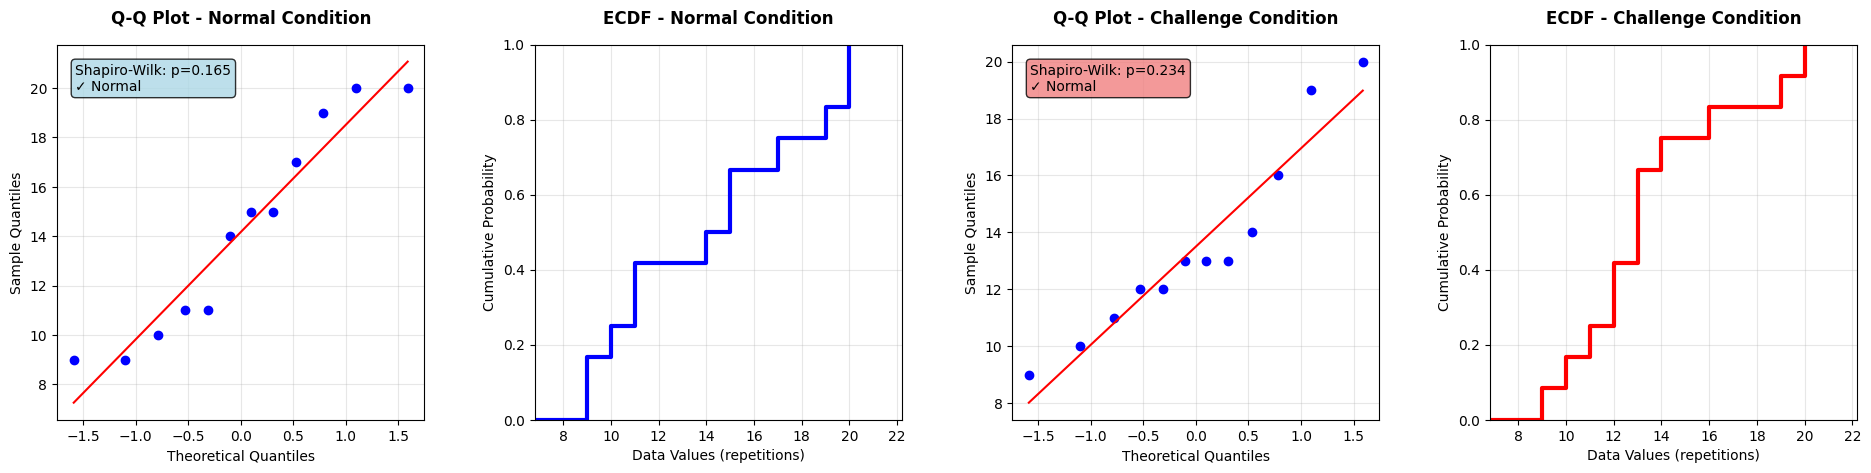

   📋 Recommendation: ✅ Both conditions normal - Proceed with paired t-test

📊 TASK 2A: WATER TASK - MOVEMENT SMOOTHNESS (JERK)

📊 Movement Smoothness (Mean Jerk) Analysis:
   Normal: [ 86.96590979 109.70631299  57.59264363  14.64503269  38.85217619
  32.11370126  37.23433453  52.03491629  35.11223049  48.10865086
  32.85263067  32.24983219] m/s³
   Challenge: [ 60.84017606 118.6818331   69.34127185  19.62488058  39.85979645
  38.526105    34.56577865  52.91125768  27.93168959  44.30767499
  33.32175954  34.61241501] m/s³
   Shapiro-Wilk Normal: W=0.8485, p=0.0351
   Shapiro-Wilk Challenge: W=0.8075, p=0.0114
💾 Combined plot saved to: normality_plots\water_task_jerk_normality.png


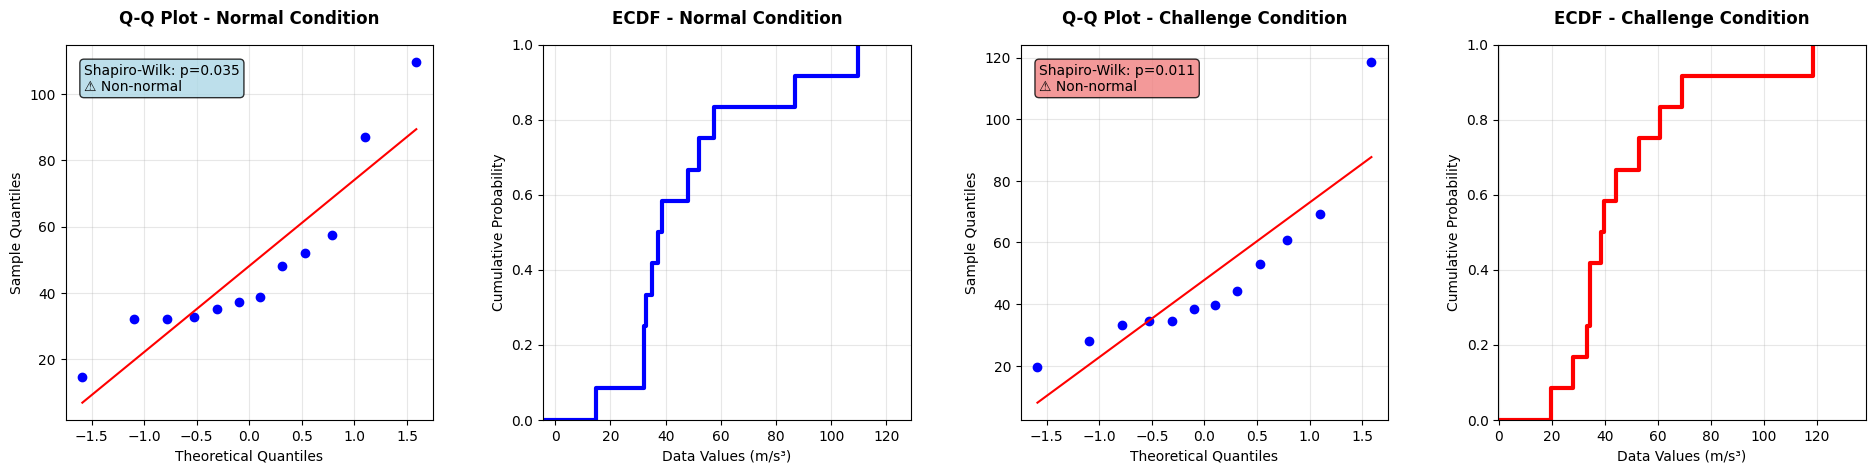

   📋 Recommendation: ⚠️ Mild deviation - Proceed with caution, consider non-parametric

📊 TASK 2B: WATER TASK - EXECUTION TIME

📊 Execution Time Analysis:
   Normal: [20.167 16.517 20.617 22.6   17.75  20.2   15.917 20.    17.767 17.567
 18.317 15.917] seconds
   Challenge: [20.917 16.667 18.967 22.267 20.    18.667 17.384 18.5   20.717 18.65
 18.95  17.567] seconds
   Shapiro-Wilk Normal: W=0.9350, p=0.4363
   Shapiro-Wilk Challenge: W=0.9604, p=0.7896
💾 Combined plot saved to: normality_plots\water_task_time_normality.png


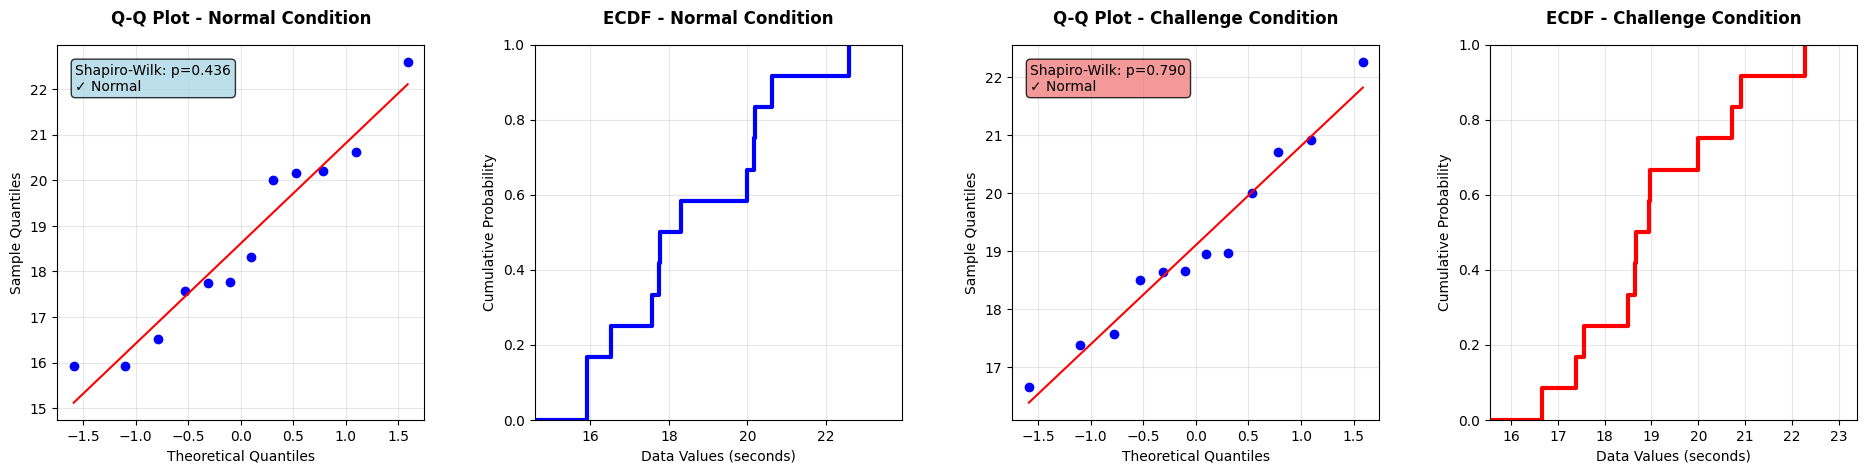

   📋 Recommendation: ✅ Both conditions normal - Proceed with paired t-test

📊 TASK 3: STEP COUNT

📊 Step Count (30s walking) Analysis:
   Normal: [53 60 50 48 46 51 44 43 55 51 48 49 51] steps
   Challenge: [56 55 51 49 49 45 43 41 54 53 45 51 54] steps
   Shapiro-Wilk Normal: W=0.9611, p=0.7700
   Shapiro-Wilk Challenge: W=0.9311, p=0.3519
💾 Combined plot saved to: normality_plots\step_count_normality.png


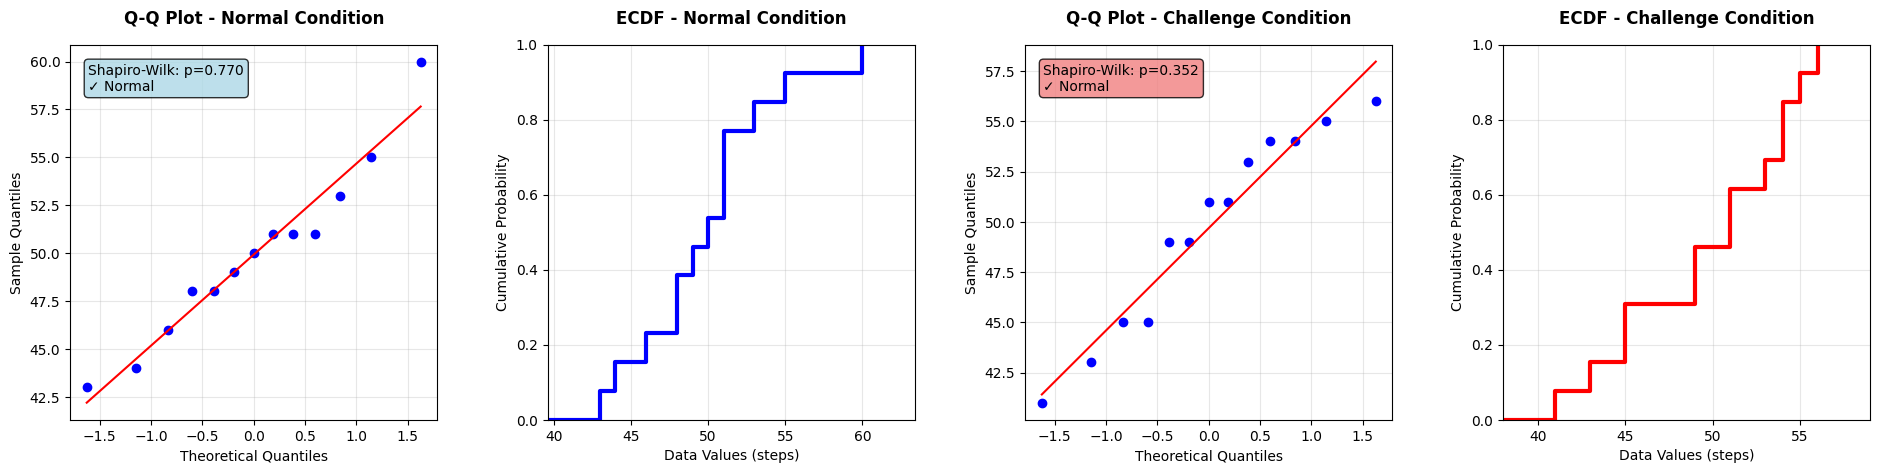

   📋 Recommendation: ✅ Both conditions normal - Proceed with paired t-test

📋 NORMALITY ASSESSMENT SUMMARY

🎯 Sit To Stand:
   Normal condition p-value: 0.1654
   Challenge condition p-value: 0.2339
   ✅ Both conditions normal - Proceed with paired t-test

🎯 Water Jerk:
   Normal condition p-value: 0.0351
   Challenge condition p-value: 0.0114
   ⚠️ Mild deviation - Proceed with caution, consider non-parametric

🎯 Water Time:
   Normal condition p-value: 0.4363
   Challenge condition p-value: 0.7896
   ✅ Both conditions normal - Proceed with paired t-test

🎯 Step Count:
   Normal condition p-value: 0.7700
   Challenge condition p-value: 0.3519
   ✅ Both conditions normal - Proceed with paired t-test

🪑 TASK 1: SIT-TO-STAND ANALYSIS

🔬 TECHNICAL REPORT ANALYSIS: SIT-TO-STAND

=== Computing Technical Report Measurements: sit_to_stand vs sit_to_stand_challenge ===

Measurement: Sit-to-Stand Repetitions (30s)
Cognitive Task: Stroop Task
Hypothesis: H1: Repetitions are LOWER with cognitive 

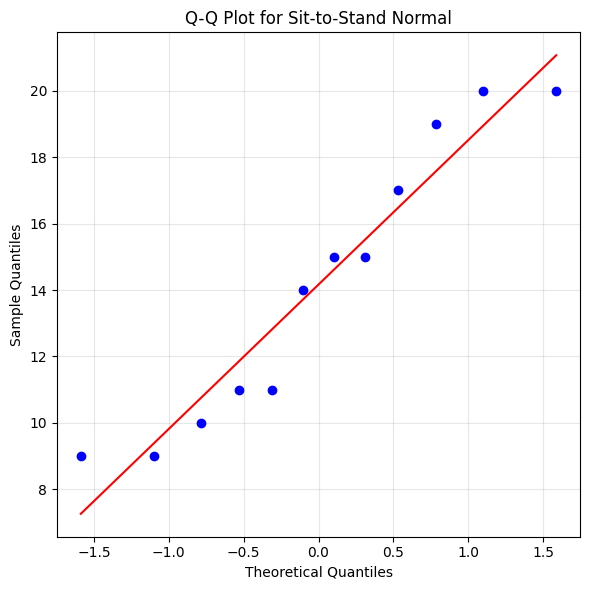

Shapiro-Wilk test for Sit-to-Stand Normal:
Statistic: 0.9014, p-value: 0.1654
✅ Data appears to be normally distributed (p > 0.05)

📊 Q-Q Plot Analysis for Sit-to-Stand Challenge
----------------------------------------


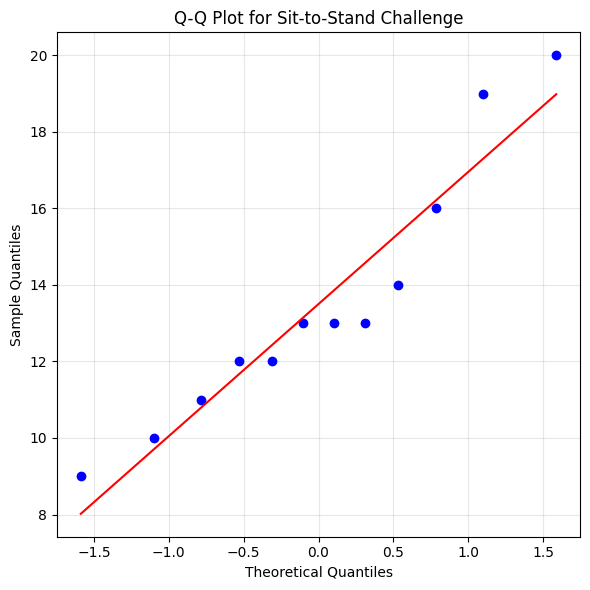

Shapiro-Wilk test for Sit-to-Stand Challenge:
Statistic: 0.9131, p-value: 0.2339
✅ Data appears to be normally distributed (p > 0.05)

🔍 Step 3: Hypothesis testing with paired t-test...

=== Paired t-test: sit_to_stand ===
Measurement: Sit-to-Stand Repetitions (30s)
Cognitive Task: Stroop Task
------------------------------------------------------------
Normal Condition:
  P1 (Anton): 15.000 repetitions
  P2 (Parisa): 11.000 repetitions
  P3 (Idrees): 10.000 repetitions
  P4 (Benno): 17.000 repetitions
  P6 (Anton): 14.000 repetitions
  P7 (Constantin): 9.000 repetitions
  P8 (Anton): 20.000 repetitions
  P9 (Thomas): 9.000 repetitions
  P10 (Thomas): 15.000 repetitions
  P11 (Nico): 11.000 repetitions
  P12 (Andrea): 20.000 repetitions
  P13 (Dennis): 19.000 repetitions

Challenge Condition (with Stroop Task):
  P1 (Anton): 16.000 repetitions
  P2 (Parisa): 12.000 repetitions
  P3 (Idrees): 11.000 repetitions
  P4 (Benno): 13.000 repetitions
  P6 (Anton): 14.000 repetitions
  P7 (Cons

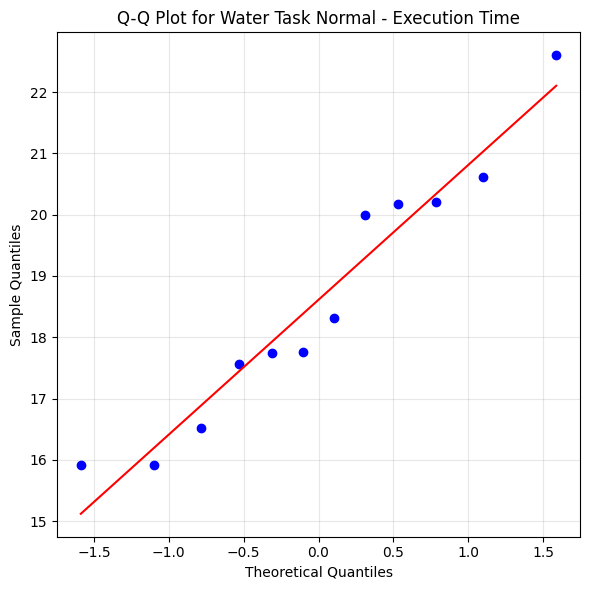

Shapiro-Wilk test for Water Task Normal - Execution Time:
Statistic: 0.9350, p-value: 0.4363
✅ Data appears to be normally distributed (p > 0.05)

📊 Q-Q Plot Analysis for Water Task Challenge - Execution Time
----------------------------------------


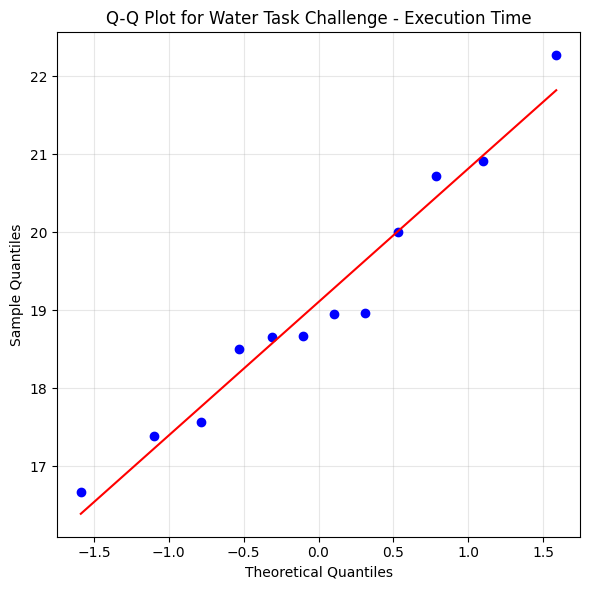

Shapiro-Wilk test for Water Task Challenge - Execution Time:
Statistic: 0.9604, p-value: 0.7896
✅ Data appears to be normally distributed (p > 0.05)

🔍 Hypothesis testing for Execution Time...

=== Paired t-test: water_task ===
Measurement: Execution Time
Cognitive Task: Verbal Fluency Test (Fruits)
------------------------------------------------------------
Normal Condition:
  P1 (Anton): 20.167 seconds
  P2 (Parisa): 16.517 seconds
  P3 (Idrees): 20.617 seconds
  P4 (Benno): 22.600 seconds
  P6 (Anton): 17.750 seconds
  P7 (Constantin): 20.200 seconds
  P8 (Anton): 15.917 seconds
  P9 (Thomas): 20.000 seconds
  P10 (Thomas): 17.767 seconds
  P11 (Nico): 17.567 seconds
  P12 (Andrea): 18.317 seconds
  P13 (Dennis): 15.917 seconds

Challenge Condition (with Verbal Fluency Test (Fruits)):
  P1 (Anton): 20.917 seconds
  P2 (Parisa): 16.667 seconds
  P3 (Idrees): 18.967 seconds
  P4 (Benno): 22.267 seconds
  P6 (Anton): 20.000 seconds
  P7 (Constantin): 18.667 seconds
  P8 (Anton): 17.38

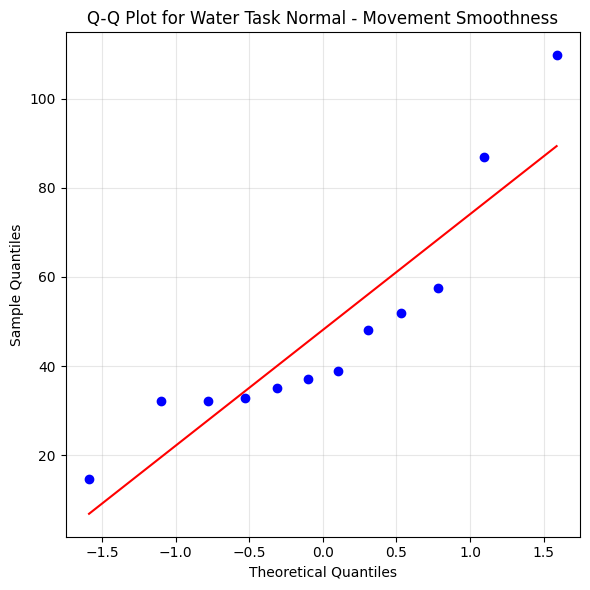

Shapiro-Wilk test for Water Task Normal - Movement Smoothness:
Statistic: 0.8485, p-value: 0.0351
⚠️ Data may not be normally distributed (p ≤ 0.05)
   Consider non-parametric tests

📊 Q-Q Plot Analysis for Water Task Challenge - Movement Smoothness
----------------------------------------


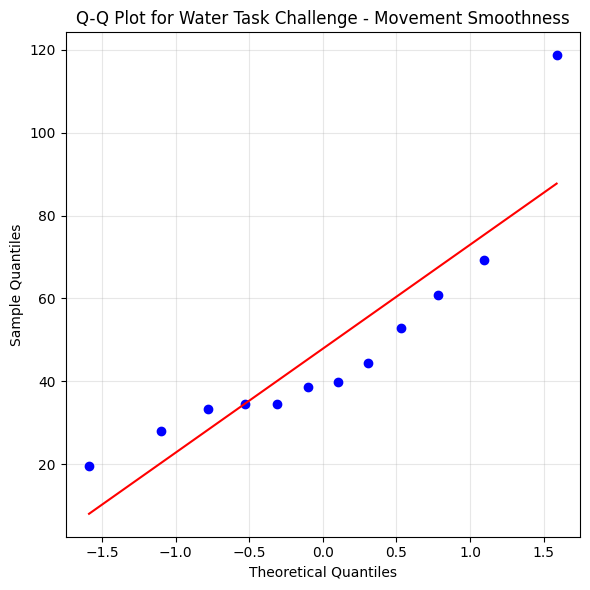

Shapiro-Wilk test for Water Task Challenge - Movement Smoothness:
Statistic: 0.8075, p-value: 0.0114
⚠️ Data may not be normally distributed (p ≤ 0.05)
   Consider non-parametric tests

🔍 Hypothesis testing for Movement Smoothness...

=== Paired t-test: water_task ===
Measurement: Movement Smoothness (Mean Jerk)
Cognitive Task: Verbal Fluency Test (Fruits)
------------------------------------------------------------
Normal Condition:
  P1 (Anton): 86.966 m/s³
  P2 (Parisa): 109.706 m/s³
  P3 (Idrees): 57.593 m/s³
  P4 (Benno): 14.645 m/s³
  P6 (Anton): 38.852 m/s³
  P7 (Constantin): 32.114 m/s³
  P8 (Anton): 37.234 m/s³
  P9 (Thomas): 52.035 m/s³
  P10 (Thomas): 35.112 m/s³
  P11 (Nico): 48.109 m/s³
  P12 (Andrea): 32.853 m/s³
  P13 (Dennis): 32.250 m/s³

Challenge Condition (with Verbal Fluency Test (Fruits)):
  P1 (Anton): 60.840 m/s³
  P2 (Parisa): 118.682 m/s³
  P3 (Idrees): 69.341 m/s³
  P4 (Benno): 19.625 m/s³
  P6 (Anton): 39.860 m/s³
  P7 (Constantin): 38.526 m/s³
  P8 (Anton):

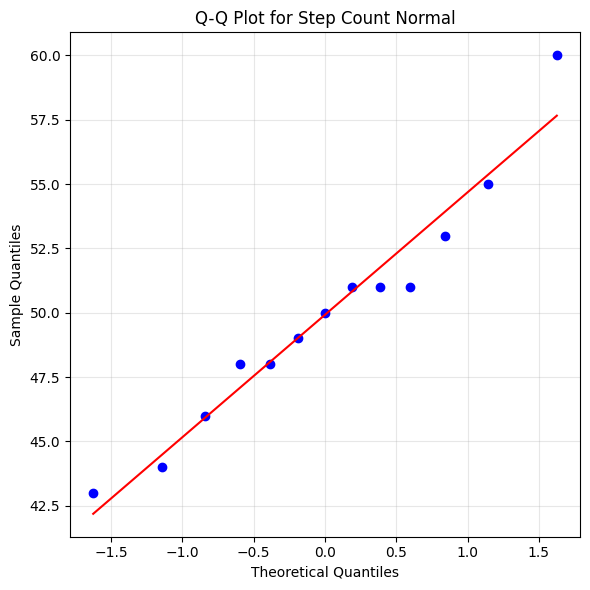

Shapiro-Wilk test for Step Count Normal:
Statistic: 0.9611, p-value: 0.7700
✅ Data appears to be normally distributed (p > 0.05)

📊 Q-Q Plot Analysis for Step Count Challenge
----------------------------------------


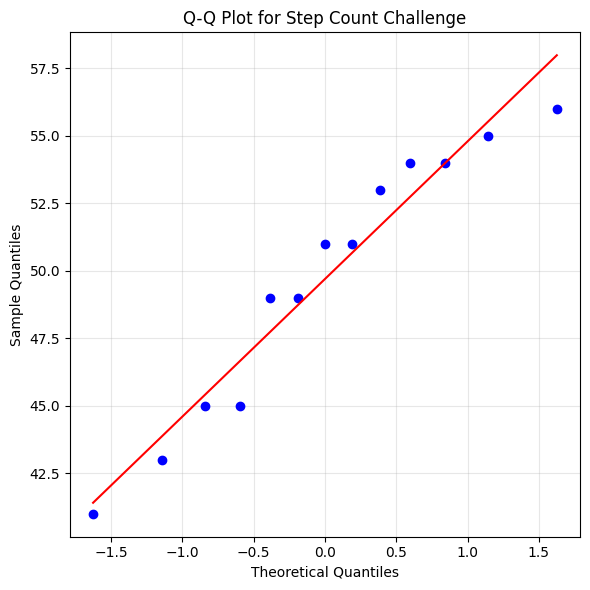

Shapiro-Wilk test for Step Count Challenge:
Statistic: 0.9311, p-value: 0.3519
✅ Data appears to be normally distributed (p > 0.05)

🔍 Step 3: Hypothesis testing with paired t-test...

=== Paired t-test: step_count ===
Measurement: Step Count (30s walking)
Cognitive Task: Task Switching
------------------------------------------------------------
Normal Condition:
  P1 (Anton): 53.000 steps
  P2 (Parisa): 60.000 steps
  P3 (Idrees): 50.000 steps
  P4 (Benno): 48.000 steps
  P5 (Jo): 46.000 steps
  P6 (Anton): 51.000 steps
  P7 (Constantin): 44.000 steps
  P8 (Anton): 43.000 steps
  P9 (Thomas): 55.000 steps
  P10 (Thomas): 51.000 steps
  P11 (Nico): 48.000 steps
  P12 (Andrea): 49.000 steps
  P13 (Dennis): 51.000 steps

Challenge Condition (with Task Switching):
  P1 (Anton): 56.000 steps
  P2 (Parisa): 55.000 steps
  P3 (Idrees): 51.000 steps
  P4 (Benno): 49.000 steps
  P5 (Jo): 49.000 steps
  P6 (Anton): 45.000 steps
  P7 (Constantin): 43.000 steps
  P8 (Anton): 41.000 steps
  P9 (T

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro, ttest_rel
import seaborn as sns
from scipy.signal import find_peaks
from scipy import ndimage


def is_hypothesis_aligned(mean_diff, alternative):
    """Helper function to check if observed difference aligns with hypothesis direction"""
    if alternative == 'greater':
        return mean_diff > 0
    elif alternative == 'less':
        return mean_diff < 0
    else:  # two-sided
        return True


class MovellaAnalyzer:
    def __init__(self, data_dict):
        """
        Initialize with your loaded data structure
        data_dict: Dictionary with structure data[task][participant_id] = {'data': df, 'name': name}
        """
        self.data_dict = data_dict
        self.target_participants = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', ]
        self.participant_names = {}

        for task in data_dict:
            for participant_id in data_dict[task]:
                if participant_id in self.target_participants:
                    self.participant_names[participant_id] = data_dict[task][participant_id]['name']

        print(f"✅ Analyzer initialized for participants: {list(self.participant_names.keys())}")
        print(f"   Participant names: {self.participant_names}")

    def calculate_magnitude(self, df, task_type):
        """Calculate acceleration magnitude from x, y, z components"""
        if 'step_count' in task_type:
            x_col = 'acceleration_m/s²_x'
            y_col = 'acceleration_m/s²_y'
            z_col = 'acceleration_m/s²_z'
        else:
            x_col = 'freeAcceleration_m/s²_x'
            y_col = 'freeAcceleration_m/s²_y'
            z_col = 'freeAcceleration_m/s²_z'

        df['magnitude'] = np.sqrt(df[x_col] ** 2 + df[y_col] ** 2 + df[z_col] ** 2)
        return df

    def count_sit_to_stand_repetitions(self, df, task_type):
        """
        Count sit-to-stand repetitions in 30 seconds
        Based on Technical Report Task 1 requirements using peak detection on vertical acceleration
        """

        # Determine the correct acceleration columns based on task type
        if 'step_count' in task_type:
            # Use total acceleration for step count tasks
            x_col = 'acceleration_m/s²_x'
            y_col = 'acceleration_m/s²_y'
            z_col = 'acceleration_m/s²_z'
        else:
            # Use free acceleration (gravity removed) for other tasks
            x_col = 'freeAcceleration_m/s²_x'
            y_col = 'freeAcceleration_m/s²_y'
            z_col = 'freeAcceleration_m/s²_z'

        # For sit-to-stand, we're primarily interested in vertical (Z-axis) acceleration
        vertical_acceleration = df[z_col].values

        # Apply smoothing to reduce noise while preserving the main movement patterns
        window_size = 5  # Smooth over ~50ms at 100Hz sampling rate
        if len(vertical_acceleration) >= window_size:
            # Pad the signal to handle edges
            padded_signal = np.pad(vertical_acceleration, (window_size // 2, window_size // 2), mode='edge')
            smoothed_acceleration = np.convolve(padded_signal, np.ones(window_size) / window_size, mode='valid')
        else:
            smoothed_acceleration = vertical_acceleration

        # Remove any DC offset by subtracting the mean
        smoothed_acceleration = smoothed_acceleration - np.mean(smoothed_acceleration)

        # Calculate signal statistics for adaptive thresholding
        signal_std = np.std(smoothed_acceleration)
        threshold = max(0.5, signal_std * 0.8)  # Minimum threshold of 0.5 m/s²
        min_distance_samples = int(0.75 * 100)  # 1.5 seconds at 100Hz

        # Find all potential positive peaks (upward acceleration during rising phase)
        potential_positive_peaks, positive_properties = find_peaks(
            smoothed_acceleration,
            height=threshold,
            distance=min_distance_samples // 3,
            prominence=threshold * 0.3
        )

        # Find all potential negative peaks (downward acceleration during preparation phase)
        potential_negative_peaks, negative_properties = find_peaks(
            -smoothed_acceleration,
            height=threshold,
            distance=min_distance_samples // 3,
            prominence=threshold * 0.3
        )

        # Create structured peak data
        all_peaks = []

        for i, peak_pos in enumerate(potential_positive_peaks):
            peak_value = smoothed_acceleration[peak_pos]
            peak_prominence = positive_properties['prominences'][i]
            all_peaks.append({
                'position': peak_pos,
                'type': 'positive',
                'value': peak_value,
                'prominence': peak_prominence
            })

        for i, peak_pos in enumerate(potential_negative_peaks):
            peak_value = smoothed_acceleration[peak_pos]
            peak_prominence = negative_properties['prominences'][i]
            all_peaks.append({
                'position': peak_pos,
                'type': 'negative',
                'value': peak_value,
                'prominence': peak_prominence
            })

        # Sort all peaks by time
        all_peaks.sort(key=lambda x: x['position'])

        # STRICT ALTERNATING PATTERN ENFORCEMENT
        valid_alternating_peaks = []
        last_accepted_type = None

        for peak in all_peaks:
            current_type = peak['type']
            current_pos = peak['position']

            if current_type != last_accepted_type:
                if (len(valid_alternating_peaks) == 0 or
                        (current_pos - valid_alternating_peaks[-1]['position']) >= (min_distance_samples // 4)):
                    valid_alternating_peaks.append(peak)
                    last_accepted_type = current_type

        # Count sit-to-stand repetitions using the strict alternating pattern
        repetitions = 0
        i = 0

        while i < len(valid_alternating_peaks) - 1:
            current_peak = valid_alternating_peaks[i]
            next_peak = valid_alternating_peaks[i + 1]

            if (current_peak['type'] == 'negative' and next_peak['type'] == 'positive'):
                time_gap = next_peak['position'] - current_peak['position']
                min_gap = int(0.2 * 100)
                max_gap = int(5.0 * 100)

                if min_gap <= time_gap <= max_gap:
                    repetitions += 1
                    i += 2
                else:
                    i += 1
            else:
                i += 1

        # Alternative counting method
        alternative_count = 0
        expecting_type = 'negative'

        for peak in valid_alternating_peaks:
            if peak['type'] == expecting_type:
                if expecting_type == 'positive':
                    alternative_count += 1
                    expecting_type = 'negative'
                else:
                    expecting_type = 'positive'

        # Use the more conservative count
        final_repetitions = min(repetitions, alternative_count)

        # Sanity check and stricter filtering if needed
        if final_repetitions > 30:
            print(f"⚠️  Warning: Detected {final_repetitions} repetitions, applying stricter filtering.")
            stricter_threshold = signal_std * 1.5
            stricter_distance = int(1 * 100)

            strict_positive_peaks, _ = find_peaks(
                smoothed_acceleration,
                height=stricter_threshold,
                distance=stricter_distance,
                prominence=stricter_threshold * 0.8
            )

            strict_negative_peaks, _ = find_peaks(
                -smoothed_acceleration,
                height=stricter_threshold,
                distance=stricter_distance,
                prominence=stricter_threshold * 0.8
            )

            strict_all_peaks = []
            for pos in strict_positive_peaks:
                strict_all_peaks.append({'position': pos, 'type': 'positive'})
            for pos in strict_negative_peaks:
                strict_all_peaks.append({'position': pos, 'type': 'negative'})

            strict_all_peaks.sort(key=lambda x: x['position'])

            strict_count = 0
            expecting = 'negative'
            for peak in strict_all_peaks:
                if peak['type'] == expecting:
                    if expecting == 'positive':
                        strict_count += 1
                        expecting = 'negative'
                    else:
                        expecting = 'positive'

            final_repetitions = strict_count

        # Final bounds check
        final_repetitions = max(0, min(final_repetitions, 50))
        return final_repetitions

    def calculate_water_task_metrics(self, df, task_type):
        """
        Calculate execution time and movement smoothness for water task
        """
        df = self.calculate_magnitude(df, task_type)

        # Calculate execution time
        if 'timestamp_ms' in df.columns:
            execution_time = (df['timestamp_ms'].iloc[-1] - df['timestamp_ms'].iloc[0]) / 1000.0
        else:
            execution_time = len(df) / 100.0

        # Calculate movement smoothness using jerk analysis
        if 'step_count' in task_type:
            x_col = 'acceleration_m/s²_x'
            y_col = 'acceleration_m/s²_y'
            z_col = 'acceleration_m/s²_z'
        else:
            x_col = 'freeAcceleration_m/s²_x'
            y_col = 'freeAcceleration_m/s²_y'
            z_col = 'freeAcceleration_m/s²_z'

        # Calculate jerk (derivative of acceleration)
        dt = 1.0 / 100.0

        jerk_x = np.gradient(df[x_col], dt)
        jerk_y = np.gradient(df[y_col], dt)
        jerk_z = np.gradient(df[z_col], dt)

        # Calculate jerk magnitude
        jerk_magnitude = np.sqrt(jerk_x ** 2 + jerk_y ** 2 + jerk_z ** 2)
        mean_jerk = np.mean(jerk_magnitude)
        rms_jerk = np.sqrt(np.mean(jerk_magnitude ** 2))

        return {
            'execution_time': execution_time,
            'mean_jerk': mean_jerk,
            'rms_jerk': rms_jerk,
            'jerk_variability': np.std(jerk_magnitude)
        }

    def count_steps_30_seconds(self, df, task_type):
        """
        Count steps during 30 seconds of walking
        """
        df = self.calculate_magnitude(df, task_type)
        magnitude = df['magnitude'].values

        # Remove gravity component and filter noise
        magnitude_filtered = magnitude - np.mean(magnitude)

        # Find peaks (steps)
        peaks, _ = find_peaks(
            magnitude_filtered,
            height=np.std(magnitude_filtered) * 0.4,
            distance=15
        )

        step_count = len(peaks)
        return step_count

    def get_task_specific_measurements(self, task_normal, task_challenge, metric_type='primary'):
        """Extract task-specific measurements based on technical report requirements"""
        normal_measurements = []
        challenge_measurements = []
        valid_participants = []
        measurement_info = {}

        for participant_id in self.target_participants:
            if (participant_id in self.data_dict.get(task_normal, {}) and
                    participant_id in self.data_dict.get(task_challenge, {})):

                normal_data = self.data_dict[task_normal][participant_id]['data'].copy()
                challenge_data = self.data_dict[task_challenge][participant_id]['data'].copy()

                # Calculate task-specific measurements
                if 'sit_to_stand' in task_normal:
                    normal_measurement = self.count_sit_to_stand_repetitions(normal_data, task_normal)
                    challenge_measurement = self.count_sit_to_stand_repetitions(challenge_data, task_challenge)
                    measurement_info = {
                        'name': 'Sit-to-Stand Repetitions (30s)',
                        'unit': 'repetitions',
                        'cognitive_task': 'Stroop Task',
                        'hypothesis': 'H1: Repetitions are LOWER with cognitive task'
                    }

                elif 'water_task' in task_normal:
                    normal_metrics = self.calculate_water_task_metrics(normal_data, task_normal)
                    challenge_metrics = self.calculate_water_task_metrics(challenge_data, task_challenge)

                    if metric_type == 'execution_time':
                        normal_measurement = normal_metrics['execution_time']
                        challenge_measurement = challenge_metrics['execution_time']
                        measurement_info = {
                            'name': 'Execution Time',
                            'unit': 'seconds',
                            'cognitive_task': 'Verbal Fluency Test (Fruits)',
                            'hypothesis': 'H1: Execution time is AFFECTED (longer) with cognitive task'
                        }
                    else:
                        normal_measurement = normal_metrics['mean_jerk']
                        challenge_measurement = challenge_metrics['mean_jerk']
                        measurement_info = {
                            'name': 'Movement Smoothness (Mean Jerk)',
                            'unit': 'm/s³',
                            'cognitive_task': 'Verbal Fluency Test (Fruits)',
                            'hypothesis': 'H1: Smoothness is AFFECTED (increased jerk) with cognitive task'
                        }

                elif 'step_count' in task_normal:
                    normal_measurement = self.count_steps_30_seconds(normal_data, task_normal)
                    challenge_measurement = self.count_steps_30_seconds(challenge_data, task_challenge)
                    measurement_info = {
                        'name': 'Step Count (30s walking)',
                        'unit': 'steps',
                        'cognitive_task': 'Task Switching',
                        'hypothesis': 'H1: Step count is LOWER with cognitive task'
                    }

                normal_measurements.append(normal_measurement)
                challenge_measurements.append(challenge_measurement)
                valid_participants.append(participant_id)

        return np.array(normal_measurements), np.array(challenge_measurements), valid_participants, measurement_info

    def compute_sample_means(self, task_normal, task_challenge, metric_type='primary'):
        """
        Compute measurements for each participant using technical report specifications
        """
        print(f"\n=== Computing Technical Report Measurements: {task_normal} vs {task_challenge} ===")

        normal_measurements, challenge_measurements, valid_participants, measurement_info = self.get_task_specific_measurements(
            task_normal, task_challenge, metric_type)

        if len(normal_measurements) == 0:
            print("❌ No participants found with both normal and challenge data!")
            return None, None, [], None

        print(f"\nMeasurement: {measurement_info['name']}")
        print(f"Cognitive Task: {measurement_info['cognitive_task']}")
        print(f"Hypothesis: {measurement_info['hypothesis']}")
        print(f"Found data for {len(valid_participants)} participants:")

        for i, participant_id in enumerate(valid_participants):
            participant_name = self.participant_names.get(participant_id, f"P{participant_id}")
            print(
                f"P{participant_id} ({participant_name}) - Normal: {normal_measurements[i]:.3f} {measurement_info['unit']}")
            print(
                f"P{participant_id} ({participant_name}) - Challenge: {challenge_measurements[i]:.3f} {measurement_info['unit']}")

        return normal_measurements, challenge_measurements, valid_participants, measurement_info

    def calculate_ecdf(self, data):
        """Calculate the Empirical Cumulative Distribution Function (ECDF)"""
        n = len(data)
        sorted_data = np.sort(data)
        ecdf_values = np.arange(1, n + 1) / n
        return sorted_data, ecdf_values

    def check_normality_qq_plot_with_ecdf(self, data, title, save_path=None):
        """
        Create Q-Q plot and ECDF plot side by side to check normality assumption
        """
        print(f"\n📊 Normality Analysis for {title}")
        print("-" * 40)

        # Create side-by-side plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Q-Q Plot
        stats.probplot(data, dist="norm", plot=ax1)
        ax1.set_xlabel('Theoretical Quantiles')
        ax1.set_ylabel('Sample Quantiles')
        ax1.grid(True, alpha=0.3)

        # ECDF Plot
        sorted_data, ecdf_values = self.calculate_ecdf(data)

        # Add padding for visualization
        data_min, data_max = np.min(sorted_data), np.max(sorted_data)
        data_range = data_max - data_min if data_max != data_min else 1
        x_start = data_min - 0.2 * data_range
        x_end = data_max + 0.2 * data_range

        x_plot = np.concatenate([[x_start], sorted_data])
        y_plot = np.concatenate([[0], ecdf_values])

        ax2.step(x_plot, y_plot, where='post', linewidth=3, color='blue')
        ax2.set_xlabel(f'Data Values')
        ax2.set_ylabel('Cumulative Probability')
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(x_start, x_end)
        ax2.set_ylim(0, 1)

        # Shapiro-Wilk test
        stat, p_value = shapiro(data)
        normality_status = "✓ Normal" if p_value > 0.05 else "⚠ Non-normal"

        # Add Shapiro-Wilk result to Q-Q plot
        ax1.text(0.05, 0.95, f'Shapiro-Wilk: p={p_value:.3f}\n{normality_status}',
                 transform=ax1.transAxes, fontsize=10, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"💾 Plot saved to: {save_path}")

        plt.show()

        print(f"Shapiro-Wilk test for {title}:")
        print(f"Statistic: {stat:.4f}, p-value: {p_value:.4f}")

        if p_value > 0.05:
            print("✅ Data appears to be normally distributed (p > 0.05)")
            is_normal = True
        else:
            print("⚠️ Data may not be normally distributed (p ≤ 0.05)")
            is_normal = False

        return stat, p_value, is_normal

    def plot_combined_normality_for_task(self, task_normal, task_challenge, metric_type='primary', save_path=None):
        """
        Create combined normality assessment plot for a single task (1x4 grid)
        Perfect for presentation slides
        """
        # Get measurements
        normal_measurements, challenge_measurements, valid_participants, measurement_info = self.get_task_specific_measurements(
            task_normal, task_challenge, metric_type)

        if len(normal_measurements) == 0:
            print(f"❌ No data found for {task_normal} vs {task_challenge}")
            return None

        # Calculate Shapiro-Wilk tests
        normal_stat, normal_p = shapiro(normal_measurements)
        challenge_stat, challenge_p = shapiro(challenge_measurements)

        print(f"\n📊 {measurement_info['name']} Analysis:")
        print(f"   Normal: {normal_measurements} {measurement_info['unit']}")
        print(f"   Challenge: {challenge_measurements} {measurement_info['unit']}")
        print(f"   Shapiro-Wilk Normal: W={normal_stat:.4f}, p={normal_p:.4f}")
        print(f"   Shapiro-Wilk Challenge: W={challenge_stat:.4f}, p={challenge_p:.4f}")

        # Create 1x4 subplot layout
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

        # === Q-Q Plot - Normal Condition ===
        stats.probplot(normal_measurements, dist="norm", plot=ax1)
        ax1.set_title('Q-Q Plot - Normal Condition', fontsize=12, fontweight='bold', pad=15)
        ax1.set_xlabel('Theoretical Quantiles')
        ax1.set_ylabel('Sample Quantiles')
        ax1.grid(True, alpha=0.3)

        # Add Shapiro-Wilk result
        normality_status = "✓ Normal" if normal_p > 0.05 else "⚠ Non-normal"
        ax1.text(0.05, 0.95, f'Shapiro-Wilk: p={normal_p:.3f}\n{normality_status}',
                 transform=ax1.transAxes, fontsize=10, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

        # === ECDF - Normal Condition ===
        sorted_data, ecdf_values = self.calculate_ecdf(normal_measurements)

        # Add padding for visualization
        data_min, data_max = np.min(sorted_data), np.max(sorted_data)
        data_range = data_max - data_min if data_max != data_min else 1
        x_start = data_min - 0.2 * data_range
        x_end = data_max + 0.2 * data_range

        x_plot = np.concatenate([[x_start], sorted_data])
        y_plot = np.concatenate([[0], ecdf_values])

        ax2.step(x_plot, y_plot, where='post', linewidth=3, color='blue')
        ax2.set_title('ECDF - Normal Condition', fontsize=12, fontweight='bold', pad=15)
        ax2.set_xlabel(f'Data Values ({measurement_info["unit"]})')
        ax2.set_ylabel('Cumulative Probability')
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(x_start, x_end)
        ax2.set_ylim(0, 1)

        # === Q-Q Plot - Challenge Condition ===
        stats.probplot(challenge_measurements, dist="norm", plot=ax3)
        ax3.set_title('Q-Q Plot - Challenge Condition', fontsize=12, fontweight='bold', pad=15)
        ax3.set_xlabel('Theoretical Quantiles')
        ax3.set_ylabel('Sample Quantiles')
        ax3.grid(True, alpha=0.3)

        # Add Shapiro-Wilk result
        normality_status = "✓ Normal" if challenge_p > 0.05 else "⚠ Non-normal"
        ax3.text(0.05, 0.95, f'Shapiro-Wilk: p={challenge_p:.3f}\n{normality_status}',
                 transform=ax3.transAxes, fontsize=10, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

        # === ECDF - Challenge Condition ===
        sorted_data, ecdf_values = self.calculate_ecdf(challenge_measurements)

        # Add padding for visualization
        data_min, data_max = np.min(sorted_data), np.max(sorted_data)
        data_range = data_max - data_min if data_max != data_min else 1
        x_start = data_min - 0.2 * data_range
        x_end = data_max + 0.2 * data_range

        x_plot = np.concatenate([[x_start], sorted_data])
        y_plot = np.concatenate([[0], ecdf_values])

        ax4.step(x_plot, y_plot, where='post', linewidth=3, color='red')
        ax4.set_title('ECDF - Challenge Condition', fontsize=12, fontweight='bold', pad=15)
        ax4.set_xlabel(f'Data Values ({measurement_info["unit"]})')
        ax4.set_ylabel('Cumulative Probability')
        ax4.grid(True, alpha=0.3)
        ax4.set_xlim(x_start, x_end)
        ax4.set_ylim(0, 1)

        # Adjust layout
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.3)

        # Save if path provided
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"💾 Combined plot saved to: {save_path}")

        plt.show()

        # Print recommendation
        if normal_p > 0.05 and challenge_p > 0.05:
            recommendation = "✅ Both conditions normal - Proceed with paired t-test"
        elif normal_p > 0.01 and challenge_p > 0.01:
            recommendation = "⚠️ Mild deviation - Proceed with caution, consider non-parametric"
        else:
            recommendation = "❌ Significant deviation - Use Wilcoxon signed-rank test"

        print(f"   📋 Recommendation: {recommendation}")

        return {
            'normal_p': normal_p,
            'challenge_p': challenge_p,
            'recommendation': recommendation,
            'normal_data': normal_measurements,
            'challenge_data': challenge_measurements
        }

    def check_normality_qq_plot(self, data, title):
        """
        Original Q-Q plot method for compatibility
        """
        print(f"\n📊 Q-Q Plot Analysis for {title}")
        print("-" * 40)

        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        stats.probplot(data, dist="norm", plot=ax)
        ax.set_title(f'Q-Q Plot for {title}')
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Sample Quantiles')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Shapiro-Wilk test for normality
        stat, p_value = shapiro(data)
        print(f"Shapiro-Wilk test for {title}:")
        print(f"Statistic: {stat:.4f}, p-value: {p_value:.4f}")

        if p_value > 0.05:
            print("✅ Data appears to be normally distributed (p > 0.05)")
            is_normal = True
        else:
            print("⚠️ Data may not be normally distributed (p ≤ 0.05)")
            print("   Consider non-parametric tests")
            is_normal = False

        return stat, p_value, is_normal

    def paired_t_test_with_hypothesis(self, normal_data, challenge_data, task_name, participants, measurement_info):
        """
        Perform paired t-test with specific hypothesis testing from technical report
        Uses correct alternative hypothesis based on expected direction of effect
        """
        print(f"\n=== Paired t-test: {task_name} ===")
        print(f"Measurement: {measurement_info['name']}")
        print(f"Cognitive Task: {measurement_info['cognitive_task']}")
        print("-" * 60)

        print(f"Normal Condition:")
        for i, p_id in enumerate(participants):
            p_name = self.participant_names.get(p_id, f"P{p_id}")
            print(f"  P{p_id} ({p_name}): {normal_data[i]:.3f} {measurement_info['unit']}")

        print(f"\nChallenge Condition (with {measurement_info['cognitive_task']}):")
        for i, p_id in enumerate(participants):
            p_name = self.participant_names.get(p_id, f"P{p_id}")
            print(f"  P{p_id} ({p_name}): {challenge_data[i]:.3f} {measurement_info['unit']}")

        # Calculate differences (Normal - Challenge)
        differences = normal_data - challenge_data
        diff_mean = np.mean(differences)
        diff_std = np.std(differences, ddof=1)
        n = len(differences)

        print(f"\nDifferences (Normal - Challenge):")
        for i, p_id in enumerate(participants):
            p_name = self.participant_names.get(p_id, f"P{p_id}")
            print(f"  P{p_id} ({p_name}): {differences[i]:.3f}")

        print(f"\nStatistical calculations:")
        print(f"Mean difference (Normal - Challenge): {diff_mean:.5f}")
        print(f"Standard deviation of differences: {diff_std:.5f}")
        print(f"Sample size (n): {n}")

        # Determine the correct alternative hypothesis based on task expectations
        if 'sit_to_stand' in task_name or 'step_count' in task_name:
            # H1: Performance is LOWER with cognitive task
            # This means Normal > Challenge, so differences should be positive
            # Alternative: 'greater' (testing if normal_data > challenge_data)
            alternative = 'greater'
            h1_description = "Performance is LOWER with cognitive task (Normal > Challenge)"
            expected_direction = "positive differences"
        elif 'water_task' in task_name:
            if 'execution_time' in measurement_info['name'].lower():
                # H1: Execution time is LONGER with cognitive task
                # This means Normal < Challenge, so differences should be negative
                # Alternative: 'less' (testing if normal_data < challenge_data)
                alternative = 'less'
                h1_description = "Execution time is LONGER with cognitive task (Normal < Challenge)"
                expected_direction = "negative differences"
            else:
                # H1: Movement smoothness is WORSE with cognitive task (higher jerk)
                # This means Normal < Challenge, so differences should be negative
                # Alternative: 'less' (testing if normal_data < challenge_data)
                alternative = 'less'
                h1_description = "Movement smoothness is WORSE with cognitive task (Normal < Challenge)"
                expected_direction = "negative differences"
        else:
            # Default to two-sided test
            alternative = 'two-sided'
            h1_description = "There is a difference between conditions"
            expected_direction = "any direction"

        # Perform paired t-test with correct alternative hypothesis
        t_stat, p_value = ttest_rel(normal_data, challenge_data, alternative=alternative)
        df = n - 1

        print(f"\nPaired t-test results:")
        print(f"Alternative hypothesis: '{alternative}' ({expected_direction})")
        print(f"t-statistic: {t_stat:.4f}")
        print(f"p-value: {p_value:.4f}")
        print(f"Degrees of freedom: {df}")

        # Hypothesis testing
        alpha = 0.05

        print(f"\n📋 HYPOTHESIS TESTING:")
        print(f"H0: {self.get_null_hypothesis(task_name)}")
        print(f"H1: {h1_description}")
        print(f"Alpha level: {alpha}")
        print(f"Test direction: {alternative}")

        # Determine if we reject null hypothesis based on the specific alternative
        if p_value < alpha:
            decision = "REJECT H0 - Support H1"

            # Provide specific interpretation based on task and direction
            if 'sit_to_stand' in task_name:
                if alternative == 'greater' and diff_mean > 0:
                    interpretation = f"Sit-to-stand repetitions are significantly LOWER with {measurement_info['cognitive_task']} (supported hypothesis)"
                else:
                    interpretation = f"Unexpected result pattern for sit-to-stand task"

            elif 'step_count' in task_name:
                if alternative == 'greater' and diff_mean > 0:
                    interpretation = f"Step count is significantly LOWER with {measurement_info['cognitive_task']} (supported hypothesis)"
                else:
                    interpretation = f"Unexpected result pattern for step count task"

            elif 'water_task' in task_name:
                if 'execution_time' in measurement_info['name'].lower():
                    if alternative == 'less' and diff_mean < 0:
                        interpretation = f"Execution time is significantly LONGER with {measurement_info['cognitive_task']} (supported hypothesis)"
                    else:
                        interpretation = f"Execution time shows unexpected pattern"
                else:  # Movement smoothness (jerk)
                    if alternative == 'less' and diff_mean < 0:
                        interpretation = f"Movement smoothness is significantly WORSE (higher jerk) with {measurement_info['cognitive_task']} (supported hypothesis)"
                    else:
                        interpretation = f"Movement smoothness shows unexpected pattern"
            else:
                interpretation = f"Significant difference detected between conditions"
        else:
            decision = "FAIL TO REJECT H0"
            interpretation = "No significant difference between conditions - insufficient evidence to support hypothesis"

        print(f"\n🎯 DECISION: {decision}")
        print(f"📊 INTERPRETATION: {interpretation}")

        # Effect size (Cohen's d)
        cohens_d = diff_mean / diff_std if diff_std != 0 else 0
        print(f"📏 Effect size (Cohen's d): {cohens_d:.3f}")

        effect_magnitude = "small" if abs(cohens_d) < 0.5 else "medium" if abs(cohens_d) < 0.8 else "large"
        print(f"   Effect magnitude: {effect_magnitude}")

        # Additional diagnostic information
        print(f"\n🔍 DIAGNOSTIC INFO:")
        print(f"   Observed mean difference: {diff_mean:.3f}")
        print(f"   Expected direction: {expected_direction}")
        print(f"   Actual direction: {'positive' if diff_mean > 0 else 'negative' if diff_mean < 0 else 'zero'}")
        print(
            f"   Hypothesis alignment: {'✅ Aligned' if is_hypothesis_aligned(diff_mean, alternative) else '❌ Not aligned'}")

        return {
            't_statistic': t_stat,
            'p_value': p_value,
            'differences': differences,
            'mean_difference': diff_mean,
            'decision': decision,
            'interpretation': interpretation,
            'cohens_d': cohens_d,
            'is_significant': p_value < alpha,
            'alternative': alternative,
            'hypothesis_aligned': is_hypothesis_aligned(diff_mean, alternative)
        }

    def get_null_hypothesis(self, task_name):
        """Return the specific null hypothesis for each task based on directional expectations"""
        if 'sit_to_stand' in task_name:
            return "H0: μ_normal ≤ μ_challenge (repetitions are not greater in normal condition)"
        elif 'water_task' in task_name:
            return "H0: μ_normal ≥ μ_challenge (execution time/jerk are not less in normal condition)"
        elif 'step_count' in task_name:
            return "H0: μ_normal ≤ μ_challenge (step count is not greater in normal condition)"
        return "H0: μ_normal = μ_challenge (no difference between conditions)"

    def create_all_normality_plots(self, save_directory="normality_plots"):
        """
        Create normality assessment plots for all tasks and save them
        """
        import os

        # Create directory if it doesn't exist
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
            print(f"📁 Created directory: {save_directory}")

        print("🎯 Creating normality assessment plots for all tasks...")

        results = {}

        # Task 1: Sit-to-Stand
        if 'sit_to_stand' in self.data_dict and 'sit_to_stand_challenge' in self.data_dict:
            print(f"\n{'=' * 50}")
            print("📊 TASK 1: SIT-TO-STAND REPETITIONS")
            print(f"{'=' * 50}")

            save_path = os.path.join(save_directory, "sit_to_stand_normality.png")
            results['sit_to_stand'] = self.plot_combined_normality_for_task(
                'sit_to_stand',
                'sit_to_stand_challenge',
                save_path=save_path
            )

        # Task 2a: Water Task - Jerk
        if 'water_task' in self.data_dict and 'water_task_challenge' in self.data_dict:
            print(f"\n{'=' * 50}")
            print("📊 TASK 2A: WATER TASK - MOVEMENT SMOOTHNESS (JERK)")
            print(f"{'=' * 50}")

            save_path = os.path.join(save_directory, "water_task_jerk_normality.png")
            results['water_jerk'] = self.plot_combined_normality_for_task(
                'water_task',
                'water_task_challenge',
                metric_type='smoothness',
                save_path=save_path
            )

            # Task 2b: Water Task - Execution Time
            print(f"\n{'=' * 50}")
            print("📊 TASK 2B: WATER TASK - EXECUTION TIME")
            print(f"{'=' * 50}")

            save_path = os.path.join(save_directory, "water_task_time_normality.png")
            results['water_time'] = self.plot_combined_normality_for_task(
                'water_task',
                'water_task_challenge',
                metric_type='execution_time',
                save_path=save_path
            )

        # Task 3: Step Count
        if 'step_count' in self.data_dict and 'step_count_challenge' in self.data_dict:
            print(f"\n{'=' * 50}")
            print("📊 TASK 3: STEP COUNT")
            print(f"{'=' * 50}")

            save_path = os.path.join(save_directory, "step_count_normality.png")
            results['step_count'] = self.plot_combined_normality_for_task(
                'step_count',
                'step_count_challenge',
                save_path=save_path
            )

        # Summary
        print(f"\n{'=' * 70}")
        print("📋 NORMALITY ASSESSMENT SUMMARY")
        print(f"{'=' * 70}")

        for task_name, result in results.items():
            if result:
                print(f"\n🎯 {task_name.replace('_', ' ').title()}:")
                print(f"   Normal condition p-value: {result['normal_p']:.4f}")
                print(f"   Challenge condition p-value: {result['challenge_p']:.4f}")
                print(f"   {result['recommendation']}")

        return results

    def analyze_task_pair(self, task_normal, task_challenge, task_display_name):
        """
        Complete analysis for a pair of tasks following technical report methodology
        """
        print(f"\n{'=' * 70}")
        print(f"🔬 TECHNICAL REPORT ANALYSIS: {task_display_name.upper()}")
        print(f"{'=' * 70}")

        results = {}

        if 'water_task' in task_normal:
            # For water task, analyze both execution time and movement smoothness separately
            print("\n🚰 WATER TASK: ANALYZING BOTH EXECUTION TIME AND MOVEMENT SMOOTHNESS")

            # Analysis 1: Execution Time
            print(f"\n{'=' * 50}")
            print("📊 ANALYSIS 1: EXECUTION TIME")
            print(f"{'=' * 50}")

            normal_exec_time, challenge_exec_time, participants_exec, measurement_info_exec = self.compute_sample_means(
                task_normal, task_challenge, metric_type='execution_time'
            )

            if normal_exec_time is not None:
                print(
                    f"\n✅ Successfully computed {measurement_info_exec['name']} for {len(participants_exec)} participants")

                # Check normality for execution time
                print("\n🔍 Checking normality assumption for Execution Time...")
                normal_stat_exec, normal_p_exec, normal_normal_exec = self.check_normality_qq_plot(
                    normal_exec_time, f"{task_display_name} Normal - Execution Time"
                )
                challenge_stat_exec, challenge_p_exec, challenge_normal_exec = self.check_normality_qq_plot(
                    challenge_exec_time, f"{task_display_name} Challenge - Execution Time"
                )

                # Hypothesis testing for execution time
                print("\n🔍 Hypothesis testing for Execution Time...")
                results_exec = self.paired_t_test_with_hypothesis(
                    normal_exec_time, challenge_exec_time, task_normal, participants_exec, measurement_info_exec
                )

                results['execution_time'] = {
                    'measurement_info': measurement_info_exec,
                    'participants': participants_exec,
                    'normal_measurements': normal_exec_time,
                    'challenge_measurements': challenge_exec_time,
                    'results': results_exec,
                    'normal_normality': normal_normal_exec,
                    'challenge_normality': challenge_normal_exec
                }

            # Analysis 2: Movement Smoothness
            print(f"\n{'=' * 50}")
            print("📊 ANALYSIS 2: MOVEMENT SMOOTHNESS")
            print(f"{'=' * 50}")

            normal_smoothness, challenge_smoothness, participants_smooth, measurement_info_smooth = self.compute_sample_means(
                task_normal, task_challenge, metric_type='smoothness'
            )

            if normal_smoothness is not None:
                print(
                    f"\n✅ Successfully computed {measurement_info_smooth['name']} for {len(participants_smooth)} participants")

                # Check normality for smoothness
                print("\n🔍 Checking normality assumption for Movement Smoothness...")
                normal_stat_smooth, normal_p_smooth, normal_normal_smooth = self.check_normality_qq_plot(
                    normal_smoothness, f"{task_display_name} Normal - Movement Smoothness"
                )
                challenge_stat_smooth, challenge_p_smooth, challenge_normal_smooth = self.check_normality_qq_plot(
                    challenge_smoothness, f"{task_display_name} Challenge - Movement Smoothness"
                )

                # Hypothesis testing for smoothness
                print("\n🔍 Hypothesis testing for Movement Smoothness...")
                results_smooth = self.paired_t_test_with_hypothesis(
                    normal_smoothness, challenge_smoothness, task_normal, participants_smooth, measurement_info_smooth
                )

                results['movement_smoothness'] = {
                    'measurement_info': measurement_info_smooth,
                    'participants': participants_smooth,
                    'normal_measurements': normal_smoothness,
                    'challenge_measurements': challenge_smoothness,
                    'results': results_smooth,
                    'normal_normality': normal_normal_smooth,
                    'challenge_normality': challenge_normal_smooth
                }

            # Combined Summary for Water Task
            print(f"\n📋 WATER TASK COMBINED SUMMARY:")
            if 'execution_time' in results:
                exec_res = results['execution_time']['results']
                print(f"   Execution Time Analysis:")
                print(f"      Mean Normal: {results['execution_time']['normal_measurements'].mean():.3f}s")
                print(f"      Mean Challenge: {results['execution_time']['challenge_measurements'].mean():.3f}s")
                print(f"      p-value: {exec_res['p_value']:.4f}")
                print(f"      Decision: {exec_res['decision']}")

            if 'movement_smoothness' in results:
                smooth_res = results['movement_smoothness']['results']
                print(f"   Movement Smoothness Analysis:")
                print(f"      Mean Normal: {results['movement_smoothness']['normal_measurements'].mean():.3f} m/s³")
                print(
                    f"      Mean Challenge: {results['movement_smoothness']['challenge_measurements'].mean():.3f} m/s³")
                print(f"      p-value: {smooth_res['p_value']:.4f}")
                print(f"      Decision: {smooth_res['decision']}")

        else:
            # For other tasks (sit-to-stand, step count), use single metric analysis
            normal_measurements, challenge_measurements, participants, measurement_info = self.compute_sample_means(
                task_normal, task_challenge)

            if normal_measurements is None or len(normal_measurements) == 0:
                print("❌ No data found for this task pair!")
                return None

            print(f"\n✅ Successfully computed {measurement_info['name']} for {len(participants)} participants")

            # Check normality assumption
            print("\n🔍 Step 2: Checking normality assumption...")

            normal_stat, normal_p, normal_normal = self.check_normality_qq_plot(
                normal_measurements, f"{task_display_name} Normal"
            )

            challenge_stat, challenge_p, challenge_normal = self.check_normality_qq_plot(
                challenge_measurements, f"{task_display_name} Challenge"
            )

            # Perform hypothesis testing
            print("\n🔍 Step 3: Hypothesis testing with paired t-test...")
            task_results = self.paired_t_test_with_hypothesis(
                normal_measurements, challenge_measurements, task_normal, participants, measurement_info
            )

            # Summary
            print(f"\n📋 TECHNICAL REPORT SUMMARY FOR {task_display_name.upper()}:")
            print(f"   Measurement: {measurement_info['name']}")
            print(f"   Cognitive Task: {measurement_info['cognitive_task']}")
            print(f"   Participants: {len(participants)}")
            print(f"   Normal condition mean: {normal_measurements.mean():.3f} ± {normal_measurements.std():.3f}")
            print(
                f"   Challenge condition mean: {challenge_measurements.mean():.3f} ± {challenge_measurements.std():.3f}")
            print(f"   Mean difference: {task_results['mean_difference']:.3f}")
            print(f"   Statistical significance: {'✅ YES' if task_results['is_significant'] else '❌ NO'}")
            print(f"   Decision: {task_results['decision']}")
            print(f"   Clinical interpretation: {task_results['interpretation']}")

            results['primary'] = {
                'measurement_info': measurement_info,
                'participants': participants,
                'normal_measurements': normal_measurements,
                'challenge_measurements': challenge_measurements,
                'results': task_results,
                'normal_normality': normal_normal,
                'challenge_normality': challenge_normal
            }

        return results


def run_technical_report_analysis(data_dict):
    """
    Run the complete analysis following the technical report specifications
    """
    print("🚀 TECHNICAL REPORT: DUAL-TASK PARADIGM ANALYSIS")
    print("=" * 70)
    print("Testing cognitive-motor interference in functional tasks")
    print("=" * 70)

    analyzer = MovellaAnalyzer(data_dict)

    print("\n📊 TECHNICAL REPORT TASK SPECIFICATIONS:")
    print("Task 1 - Sit-to-Stand: 30s repetitions + Stroop Task")
    print("Task 2 - Water Task: Execution time & smoothness + Verbal Fluency (Fruits)")
    print("Task 3 - Step Count: 30s walking + Task Switching")

    # Create normality plots first
    normality_results = analyzer.create_all_normality_plots()

    results = {}

    # Task 1: Sit-to-Stand Analysis
    if 'sit_to_stand' in data_dict and 'sit_to_stand_challenge' in data_dict:
        print(f"\n{'=' * 50}")
        print("🪑 TASK 1: SIT-TO-STAND ANALYSIS")
        results['sit_to_stand'] = analyzer.analyze_task_pair(
            'sit_to_stand', 'sit_to_stand_challenge', 'Sit-to-Stand'
        )

    # Task 2: Water Task Analysis
    if 'water_task' in data_dict and 'water_task_challenge' in data_dict:
        print(f"\n{'=' * 50}")
        print("🚰 TASK 2: WATER TASK ANALYSIS")
        results['water_task'] = analyzer.analyze_task_pair(
            'water_task', 'water_task_challenge', 'Water Task'
        )

    # Task 3: Step Count Analysis
    if 'step_count' in data_dict and 'step_count_challenge' in data_dict:
        print(f"\n{'=' * 50}")
        print("🚶 TASK 3: STEP COUNT ANALYSIS")
        results['step_count'] = analyzer.analyze_task_pair(
            'step_count', 'step_count_challenge', 'Step Count'
        )

    # Final Technical Report Summary
    print("\n" + "=" * 70)
    print("📊 TECHNICAL REPORT: FINAL SUMMARY")
    print("=" * 70)

    for task_name, result in results.items():
        if result is not None:
            task_display = task_name.replace('_', ' ').title()

            if task_name == 'water_task':
                # Special handling for water task with multiple metrics
                print(f"\n🎯 {task_display}:")

                if 'execution_time' in result:
                    exec_info = result['execution_time']
                    exec_res = exec_info['results']
                    print(f"   📊 Execution Time Analysis:")
                    print(f"      Cognitive Task: {exec_info['measurement_info']['cognitive_task']}")
                    print(f"      Participants: {len(exec_info['participants'])}")
                    print(f"      p-value: {exec_res['p_value']:.4f}")
                    print(f"      Effect size: {exec_res['cohens_d']:.3f}")
                    print(f"      Decision: {exec_res['decision']}")
                    print(f"      Conclusion: {exec_res['interpretation']}")

                if 'movement_smoothness' in result:
                    smooth_info = result['movement_smoothness']
                    smooth_res = smooth_info['results']
                    print(f"   📊 Movement Smoothness Analysis:")
                    print(f"      Cognitive Task: {smooth_info['measurement_info']['cognitive_task']}")
                    print(f"      Participants: {len(smooth_info['participants'])}")
                    print(f"      p-value: {smooth_res['p_value']:.4f}")
                    print(f"      Effect size: {smooth_res['cohens_d']:.3f}")
                    print(f"      Decision: {smooth_res['decision']}")
                    print(f"      Conclusion: {smooth_res['interpretation']}")
            else:
                # Standard handling for other tasks
                if 'primary' in result:
                    measurement = result['primary']['measurement_info']
                    res = result['primary']['results']

                    print(f"\n🎯 {task_display}:")
                    print(f"   Measurement: {measurement['name']}")
                    print(f"   Cognitive Task: {measurement['cognitive_task']}")
                    print(f"   Participants: {len(result['primary']['participants'])}")
                    print(f"   p-value: {res['p_value']:.4f}")
                    print(f"   Effect size: {res['cohens_d']:.3f}")
                    print(f"   Decision: {res['decision']}")
                    print(f"   Conclusion: {res['interpretation']}")
        else:
            print(f"\n❌ {task_name.replace('_', ' ').title()}: Insufficient data")

    print(f"\n🏁 TECHNICAL REPORT ANALYSIS COMPLETE!")
    print("\n💡 CLINICAL IMPLICATIONS:")
    print("   • Significant results indicate cognitive-motor interference")
    print("   • Effect sizes help determine clinical relevance")
    print("   • Dual-task deficits may predict fall risk and functional decline")

    return results


# Usage example:
base_dir = "."
recordings_df, csv_files = explore_data_structure(base_dir)
data = load_data_files(recordings_df, base_dir)
results = run_technical_report_analysis(data)
#
# Or create normality plots separately:
# analyzer = MovellaAnalyzer(data)
# normality_results = analyzer.create_all_normality_plots(save_directory="my_plots")

In [19]:
data

{'step_count': {'1': {'data':        timestamp_ms  acceleration_m/s²_x  acceleration_m/s²_y  \
   0     1747566890543            -0.161010             3.057171   
   1     1747566890563            -0.196923             3.043928   
   2     1747566890583            -0.151134             3.036521   
   3     1747566890603            -0.091952             2.987365   
   4     1747566890623            -0.192210             2.960281   
   ...             ...                  ...                  ...   
   1461  1747566920449            -2.227580             1.295338   
   1462  1747566920469            -1.590423             1.045443   
   1463  1747566920489            -1.044994             1.116371   
   1464  1747566920510            -0.970549             1.361029   
   1465  1747566920529            -1.264812             1.500940   
   
         acceleration_m/s²_z  
   0                9.162684  
   1                9.281571  
   2                9.497349  
   3                9.502362 

In [23]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_auc_score,
                             balanced_accuracy_score, matthews_corrcoef)
from sklearn.pipeline import Pipeline
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

class NonWindowedMLAnalyzer:
    def __init__(self, data_dict):
        self.data_dict = data_dict
        self.features_df = None
        self.results = {}

    def extract_features_from_entire_recording(self, df, task_type):
        """Extract features from entire recording (no windowing)"""
        features = {}

        # Determine column names
        if 'step_count' in task_type:
            x_col, y_col, z_col = 'acceleration_m/s²_x', 'acceleration_m/s²_y', 'acceleration_m/s²_z'
        else:
            x_col = 'freeAcceleration_m/s²_x'
            y_col = 'freeAcceleration_m/s²_y'
            z_col = 'freeAcceleration_m/s²_z'

        # Calculate magnitude
        magnitude = np.sqrt(df[x_col]**2 + df[y_col]**2 + df[z_col]**2)

        # Time domain features for each axis and magnitude
        for axis, data in [('x', df[x_col]), ('y', df[y_col]), ('z', df[z_col]), ('mag', magnitude)]:
            # Basic statistics
            features[f'{axis}_mean'] = np.mean(data)
            features[f'{axis}_std'] = np.std(data)
            features[f'{axis}_min'] = np.min(data)
            features[f'{axis}_max'] = np.max(data)
            features[f'{axis}_range'] = np.max(data) - np.min(data)
            features[f'{axis}_rms'] = np.sqrt(np.mean(data**2))
            features[f'{axis}_var'] = np.var(data)
            features[f'{axis}_skewness'] = skew(data)
            features[f'{axis}_kurtosis'] = kurtosis(data)
            features[f'{axis}_q25'] = np.percentile(data, 25)
            features[f'{axis}_q75'] = np.percentile(data, 75)
            features[f'{axis}_iqr'] = features[f'{axis}_q75'] - features[f'{axis}_q25']

        # Task-specific features
        if 'step_count' in task_type:
            peaks, _ = find_peaks(magnitude, height=np.mean(magnitude) + 0.3*np.std(magnitude), distance=20)
            features['total_steps'] = len(peaks)
            features['step_regularity'] = np.std(np.diff(peaks)) if len(peaks) > 1 else 0
            features['activity_level'] = np.mean(magnitude)

        elif 'sit_to_stand' in task_type:
            peaks, _ = find_peaks(magnitude, height=np.mean(magnitude) + 0.2*np.std(magnitude), distance=60)
            features['total_repetitions'] = len(peaks)
            jerk = np.diff(magnitude)
            features['movement_smoothness'] = -np.mean(np.abs(jerk))
            features['jerk_std'] = np.std(jerk)

        elif 'water_task' in task_type:
            features['execution_time'] = len(df) / 60  # Assuming 60Hz
            jerk = np.diff(magnitude)
            features['movement_smoothness'] = -np.mean(np.abs(jerk))
            features['jerk_variance'] = np.var(jerk)
            if len(magnitude) > 10:
                fft_vals = np.abs(np.fft.fft(magnitude))
                features['high_freq_power'] = np.sum(fft_vals[len(fft_vals)//4:len(fft_vals)//2])
            else:
                features['high_freq_power'] = 0

        # Frequency domain features
        if len(magnitude) > 4:
            fft_mag = np.abs(np.fft.fft(magnitude))
            freqs = np.fft.fftfreq(len(magnitude))
            power_spectrum = fft_mag**2

            features['spectral_energy'] = np.sum(power_spectrum)
            features['dominant_freq_idx'] = np.argmax(power_spectrum[:len(power_spectrum)//2])

            if np.sum(power_spectrum[:len(power_spectrum)//2]) > 0:
                features['spectral_centroid'] = (
                        np.sum(freqs[:len(freqs)//2] * power_spectrum[:len(power_spectrum)//2]) /
                        np.sum(power_spectrum[:len(power_spectrum)//2])
                )
            else:
                features['spectral_centroid'] = 0

        return features

    def create_non_windowed_dataset(self):
        """Create dataset from entire recordings (no windowing)"""
        all_features = []

        task_pairs = [
            ('step_count', 'step_count_challenge'),
            ('sit_to_stand', 'sit_to_stand_challenge'),
            ('water_task', 'water_task_challenge')
        ]

        for normal_task, challenge_task in task_pairs:
            if normal_task in self.data_dict and challenge_task in self.data_dict:
                print(f"\n📊 Processing {normal_task} (non-windowed)...")

                normal_participants = set(self.data_dict[normal_task].keys())
                challenge_participants = set(self.data_dict[challenge_task].keys())
                common_participants = normal_participants.intersection(challenge_participants)

                print(f"   Found {len(common_participants)} participants with both conditions")

                for participant_id in common_participants:
                    # Normal condition
                    normal_data = self.data_dict[normal_task][participant_id]['data']
                    normal_features = self.extract_features_from_entire_recording(normal_data, normal_task)
                    normal_features['participant_id'] = participant_id
                    normal_features['task'] = normal_task
                    normal_features['condition'] = 'normal'
                    normal_features['label'] = 0
                    all_features.append(normal_features)

                    # Challenge condition
                    challenge_data = self.data_dict[challenge_task][participant_id]['data']
                    challenge_features = self.extract_features_from_entire_recording(challenge_data, normal_task)
                    challenge_features['participant_id'] = participant_id
                    challenge_features['task'] = normal_task
                    challenge_features['condition'] = 'challenge'
                    challenge_features['label'] = 1
                    all_features.append(challenge_features)

                    print(f"   P{participant_id}: Normal({normal_data.shape[0]} samples) + Challenge({challenge_data.shape[0]} samples)")

        self.features_df = pd.DataFrame(all_features)
        print(f"\n✅ Created non-windowed dataset: {self.features_df.shape[0]} samples, {self.features_df.shape[1]} features")
        return self.features_df

    def calculate_comprehensive_metrics(self, y_true, y_pred, y_pred_proba=None):
        """Calculate comprehensive evaluation metrics"""
        metrics = {}

        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred)
        metrics['precision'] = precision_score(y_true, y_pred, average='binary', zero_division=0)
        metrics['recall'] = recall_score(y_true, y_pred, average='binary', zero_division=0)
        metrics['f1_score'] = f1_score(y_true, y_pred, average='binary', zero_division=0)
        metrics['specificity'] = recall_score(y_true, y_pred, pos_label=0, average='binary', zero_division=0)
        metrics['matthews_corrcoef'] = matthews_corrcoef(y_true, y_pred)

        if y_pred_proba is not None:
            try:
                metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
            except:
                metrics['roc_auc'] = np.nan
        else:
            metrics['roc_auc'] = np.nan

        return metrics

    def run_non_windowed_ml_analysis(self):
        """Run ML analysis on non-windowed data"""
        if self.features_df is None:
            self.create_non_windowed_dataset()

        print("\n" + "="*80)
        print("🤖 NON-WINDOWED MACHINE LEARNING ANALYSIS")
        print("="*80)

        results = {}

        for task in self.features_df['task'].unique():
            print(f"\n🎯 Analyzing {task.upper().replace('_', ' ')} (Non-Windowed)...")

            task_data = self.features_df[self.features_df['task'] == task].copy()

            if len(task_data) < 4:
                print(f"   ⚠️ Insufficient data: {len(task_data)} samples")
                continue

            feature_cols = [col for col in task_data.columns
                            if col not in ['participant_id', 'task', 'condition', 'label']]

            X = task_data[feature_cols].fillna(0)
            y = task_data['label']
            participant_ids = task_data['participant_id']

            print(f"   📊 Data: {len(X)} recordings, {len(feature_cols)} features")
            print(f"   👥 Participants: {len(participant_ids.unique())}")
            print(f"   🏷️ Labels: {y.value_counts().to_dict()}")

            # Feature selection
            k_features = min(10, len(feature_cols))
            selector = SelectKBest(score_func=f_classif, k=k_features)
            X_selected = selector.fit_transform(X, y)
            selected_features = [feature_cols[i] for i in selector.get_support(indices=True)]

            print(f"   🔍 Selected top {k_features} features:")
            for i, feat in enumerate(selected_features[:5]):
                score = selector.scores_[selector.get_support()][i]
                print(f"      {feat}: {score:.2f}")

            models = {
                'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5),
                'SVM': SVC(kernel='rbf', random_state=42, probability=True),
                'K-NN': KNeighborsClassifier(n_neighbors=3),
                'Naive Bayes': GaussianNB()
            }

            print(f"   🔄 Leave-One-Subject-Out Cross-Validation:")
            print(f"   {'Model':<15} {'Accuracy':<8} {'F1':<6} {'Precision':<9} {'Recall':<7} {'Specificity':<11} {'ROC-AUC':<7}")
            print(f"   {'-'*70}")

            task_results = {}
            for model_name, model in models.items():
                pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('classifier', model)
                ])

                all_metrics = defaultdict(list)
                unique_participants = participant_ids.unique()

                all_y_true = []
                all_y_pred = []
                all_y_pred_proba = []

                for test_participant in unique_participants:
                    train_mask = participant_ids != test_participant
                    test_mask = participant_ids == test_participant

                    X_train, X_test = X_selected[train_mask], X_selected[test_mask]
                    y_train, y_test = y[train_mask], y[test_mask]

                    if len(np.unique(y_train)) < 2 or len(y_test) == 0:
                        continue

                    pipeline.fit(X_train, y_train)
                    y_pred = pipeline.predict(X_test)

                    try:
                        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
                    except:
                        y_pred_proba = None

                    fold_metrics = self.calculate_comprehensive_metrics(y_test, y_pred, y_pred_proba)

                    for metric_name, value in fold_metrics.items():
                        if not np.isnan(value):
                            all_metrics[metric_name].append(value)

                    all_y_true.extend(y_test)
                    all_y_pred.extend(y_pred)
                    if y_pred_proba is not None:
                        all_y_pred_proba.extend(y_pred_proba)

                if all_metrics:
                    mean_metrics = {metric: np.mean(values) for metric, values in all_metrics.items()}

                    print(f"   {model_name:<15} "
                          f"{mean_metrics['accuracy']:.3f}    "
                          f"{mean_metrics['f1_score']:.3f}  "
                          f"{mean_metrics['precision']:.3f}     "
                          f"{mean_metrics['recall']:.3f}   "
                          f"{mean_metrics['specificity']:.3f}       "
                          f"{mean_metrics.get('roc_auc', 0):.3f}")

                    task_results[model_name] = {
                        'mean_metrics': mean_metrics,
                        'all_y_true': all_y_true,
                        'all_y_pred': all_y_pred,
                        'confusion_matrix': confusion_matrix(all_y_true, all_y_pred),
                        'n_samples': len(all_y_true)
                    }

            if task_results:
                best_model = max(task_results.keys(), key=lambda x: task_results[x]['mean_metrics']['f1_score'])
                best_result = task_results[best_model]

                print(f"\n   🏆 Best Model: {best_model} (F1-Score: {best_result['mean_metrics']['f1_score']:.3f})")
                print(f"   📊 Samples analyzed: {best_result['n_samples']}")

                cm = best_result['confusion_matrix']
                print(f"   📊 Confusion Matrix:")
                print(f"      {'Predicted':<12} Normal  Challenge")
                print(f"      Normal        {cm[0,0]:<6} {cm[0,1]:<6}")
                print(f"      Challenge     {cm[1,0]:<6} {cm[1,1]:<6}")

                f1_score_val = best_result['mean_metrics']['f1_score']
                accuracy_val = best_result['mean_metrics']['accuracy']

                if f1_score_val > 0.8 and accuracy_val > 0.8:
                    interpretation = "🟢 Excellent detection of cognitive-motor interference"
                elif f1_score_val > 0.7 and accuracy_val > 0.7:
                    interpretation = "🟡 Good detection of cognitive-motor interference"
                elif f1_score_val > 0.6 and accuracy_val > 0.6:
                    interpretation = "🟠 Moderate detection of cognitive-motor interference"
                else:
                    interpretation = "🔴 Weak detection of cognitive-motor interference"

                print(f"   💡 Interpretation: {interpretation}")

                results[task] = {
                    'best_model': best_model,
                    'best_f1_score': f1_score_val,
                    'best_accuracy': accuracy_val,
                    'interpretation': interpretation,
                    'selected_features': selected_features,
                    'detailed_results': task_results,
                    'confusion_matrix': cm,
                    'n_samples': best_result['n_samples']
                }

        print(f"\n" + "="*80)
        print("📋 NON-WINDOWED ANALYSIS SUMMARY")
        print("="*80)

        summary_table = []
        for task, result in results.items():
            best_metrics = result['detailed_results'][result['best_model']]['mean_metrics']
            summary_table.append({
                'Task': task.replace('_', ' ').title(),
                'Best Model': result['best_model'],
                'Samples': result['n_samples'],
                'F1-Score': f"{best_metrics['f1_score']:.3f}",
                'Accuracy': f"{best_metrics['accuracy']:.3f}",
                'Precision': f"{best_metrics['precision']:.3f}",
                'Recall': f"{best_metrics['recall']:.3f}",
                'ROC-AUC': f"{best_metrics.get('roc_auc', 0):.3f}",
                'Interpretation': result['interpretation']
            })

        summary_df = pd.DataFrame(summary_table)
        print(summary_df.to_string(index=False))

        self.results = results
        return results

# Run non-windowed analysis
print("🚀 NON-WINDOWED MACHINE LEARNING ANALYSIS")
print("="*60)

non_windowed_analyzer = NonWindowedMLAnalyzer(data)
non_windowed_features_df = non_windowed_analyzer.create_non_windowed_dataset()

print("\n" + "="*80)
print("📋 NON-WINDOWED DATASET OVERVIEW")
print("="*80)

print(f"Dataset shape: {non_windowed_features_df.shape}")
print(f"Tasks: {non_windowed_features_df['task'].unique()}")
print(f"Participants: {sorted(non_windowed_features_df['participant_id'].unique())}")
print(f"Conditions: {non_windowed_features_df['condition'].unique()}")

feature_cols = [col for col in non_windowed_features_df.columns
                if col not in ['participant_id', 'task', 'condition', 'label']]
print(f"\nExtracted Features ({len(feature_cols)} total):")
print(f"Sample features: {feature_cols[:10]}")

print(f"\nData Distribution by Task and Condition:")
task_summary = non_windowed_features_df.groupby(['task', 'condition']).size().unstack(fill_value=0)
print(task_summary)

non_windowed_results = non_windowed_analyzer.run_non_windowed_ml_analysis()

print(f"\n✅ Non-Windowed Analysis Complete!")


🚀 NON-WINDOWED MACHINE LEARNING ANALYSIS

📊 Processing step_count (non-windowed)...
   Found 13 participants with both conditions
   P5: Normal(1461 samples) + Challenge(1434 samples)
   P7: Normal(1229 samples) + Challenge(1190 samples)
   P6: Normal(1464 samples) + Challenge(1453 samples)
   P13: Normal(1449 samples) + Challenge(1467 samples)
   P11: Normal(1227 samples) + Challenge(1231 samples)
   P3: Normal(1465 samples) + Challenge(1453 samples)
   P12: Normal(1464 samples) + Challenge(1461 samples)
   P1: Normal(1466 samples) + Challenge(1463 samples)
   P2: Normal(1468 samples) + Challenge(1468 samples)
   P8: Normal(1214 samples) + Challenge(1194 samples)
   P10: Normal(1204 samples) + Challenge(1232 samples)
   P4: Normal(1441 samples) + Challenge(1436 samples)
   P9: Normal(1223 samples) + Challenge(1231 samples)

📊 Processing sit_to_stand (non-windowed)...
   Found 12 participants with both conditions
   P7: Normal(3582 samples) + Challenge(3575 samples)
   P6: Normal(3592 

In [24]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_auc_score,
                             balanced_accuracy_score, matthews_corrcoef)
from sklearn.pipeline import Pipeline
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

class WindowedMLAnalyzer:
    def __init__(self, data_dict):
        self.data_dict = data_dict
        self.windowed_features_df = None
        self.results = {}

        self.window_configs = {
            'step_count': {
                'window_size_seconds': 3.0,
                'overlap': 0.5,
                'sampling_rate': 50
            },
            'sit_to_stand': {
                'window_size_seconds': 4.0,
                'overlap': 0.5,
                'sampling_rate': 60
            },
            'water_task': {
                'window_size_seconds': 3.0,
                'overlap': 0.5,
                'sampling_rate': 60
            }
        }

    def extract_windows(self, df, task_type):
        """Extract overlapping windows from continuous sensor data"""
        config = self.window_configs[task_type]

        window_size_samples = int(config['window_size_seconds'] * config['sampling_rate'])
        overlap_samples = int(window_size_samples * config['overlap'])
        step_size = window_size_samples - overlap_samples

        windows = []

        for start in range(0, len(df) - window_size_samples + 1, step_size):
            end = start + window_size_samples
            window = df.iloc[start:end].copy()

            if self.has_sufficient_movement(window, task_type):
                windows.append(window)

        return windows

    def has_sufficient_movement(self, window, task_type):
        """Check if window contains sufficient movement"""
        if 'step_count' in task_type:
            x_col, y_col, z_col = 'acceleration_m/s²_x', 'acceleration_m/s²_y', 'acceleration_m/s²_z'
        else:
            x_col = 'freeAcceleration_m/s²_x'
            y_col = 'freeAcceleration_m/s²_y'
            z_col = 'freeAcceleration_m/s²_z'

        magnitude = np.sqrt(window[x_col]**2 + window[y_col]**2 + window[z_col]**2)
        movement_threshold = 0.1
        return np.std(magnitude) > movement_threshold

    def extract_window_features(self, window, task_type):
        """Extract comprehensive features from a single window"""
        features = {}

        if 'step_count' in task_type:
            x_col, y_col, z_col = 'acceleration_m/s²_x', 'acceleration_m/s²_y', 'acceleration_m/s²_z'
        else:
            x_col = 'freeAcceleration_m/s²_x'
            y_col = 'freeAcceleration_m/s²_y'
            z_col = 'freeAcceleration_m/s²_z'

        magnitude = np.sqrt(window[x_col]**2 + window[y_col]**2 + window[z_col]**2)

        for axis, data in [('x', window[x_col]), ('y', window[y_col]), ('z', window[z_col]), ('mag', magnitude)]:
            features[f'{axis}_mean'] = np.mean(data)
            features[f'{axis}_std'] = np.std(data)
            features[f'{axis}_min'] = np.min(data)
            features[f'{axis}_max'] = np.max(data)
            features[f'{axis}_range'] = np.max(data) - np.min(data)
            features[f'{axis}_rms'] = np.sqrt(np.mean(data**2))
            features[f'{axis}_var'] = np.var(data)

            if len(data) > 3:
                features[f'{axis}_skewness'] = skew(data)
                features[f'{axis}_kurtosis'] = kurtosis(data)
            else:
                features[f'{axis}_skewness'] = 0
                features[f'{axis}_kurtosis'] = 0

            features[f'{axis}_q25'] = np.percentile(data, 25)
            features[f'{axis}_q75'] = np.percentile(data, 75)
            features[f'{axis}_iqr'] = features[f'{axis}_q75'] - features[f'{axis}_q25']

        # Task-specific features
        if 'step_count' in task_type:
            peaks, _ = find_peaks(magnitude, height=np.mean(magnitude) + 0.3*np.std(magnitude), distance=10)
            features['peak_count'] = len(peaks)
            features['step_regularity'] = np.std(np.diff(peaks)) if len(peaks) > 1 else 0
            features['activity_level'] = np.mean(magnitude)

        elif 'sit_to_stand' in task_type:
            peaks, _ = find_peaks(magnitude, height=np.mean(magnitude) + 0.2*np.std(magnitude), distance=20)
            features['transition_count'] = len(peaks)
            jerk = np.diff(magnitude)
            features['movement_smoothness'] = -np.mean(np.abs(jerk))
            features['jerk_std'] = np.std(jerk)

        elif 'water_task' in task_type:
            jerk = np.diff(magnitude)
            features['movement_smoothness'] = -np.mean(np.abs(jerk))
            features['jerk_variance'] = np.var(jerk)
            if len(magnitude) > 10:
                fft_vals = np.abs(np.fft.fft(magnitude))
                features['high_freq_power'] = np.sum(fft_vals[len(fft_vals)//4:len(fft_vals)//2])
            else:
                features['high_freq_power'] = 0

        # Frequency domain features
        if len(magnitude) > 4:
            fft_mag = np.abs(np.fft.fft(magnitude))
            freqs = np.fft.fftfreq(len(magnitude))
            power_spectrum = fft_mag**2

            features['spectral_energy'] = np.sum(power_spectrum)
            features['dominant_freq_idx'] = np.argmax(power_spectrum[:len(power_spectrum)//2])

            if np.sum(power_spectrum[:len(power_spectrum)//2]) > 0:
                features['spectral_centroid'] = (
                        np.sum(freqs[:len(freqs)//2] * power_spectrum[:len(power_spectrum)//2]) /
                        np.sum(power_spectrum[:len(power_spectrum)//2])
                )
            else:
                features['spectral_centroid'] = 0
        else:
            features['spectral_energy'] = 0
            features['dominant_freq_idx'] = 0
            features['spectral_centroid'] = 0

        return features

    def create_windowed_dataset(self):
        """Create windowed dataset from existing data"""
        all_windowed_data = []

        task_pairs = [
            ('step_count', 'step_count_challenge'),
            ('sit_to_stand', 'sit_to_stand_challenge'),
            ('water_task', 'water_task_challenge')
        ]

        for normal_task, challenge_task in task_pairs:
            if normal_task in self.data_dict and challenge_task in self.data_dict:
                print(f"\n📊 Processing {normal_task} with windowing...")

                normal_participants = set(self.data_dict[normal_task].keys())
                challenge_participants = set(self.data_dict[challenge_task].keys())
                common_participants = normal_participants.intersection(challenge_participants)

                print(f"   Found {len(common_participants)} participants with both conditions")

                total_windows = 0

                for participant_id in common_participants:
                    # Process normal condition
                    normal_data = self.data_dict[normal_task][participant_id]['data']
                    normal_windows = self.extract_windows(normal_data, normal_task)

                    for i, window in enumerate(normal_windows):
                        window_features = self.extract_window_features(window, normal_task)

                        window_data = {
                            'participant_id': participant_id,
                            'task': normal_task,
                            'condition': 'normal',
                            'label': 0,
                            'window_id': i,
                            **window_features
                        }
                        all_windowed_data.append(window_data)

                    # Process challenge condition
                    challenge_data = self.data_dict[challenge_task][participant_id]['data']
                    challenge_windows = self.extract_windows(challenge_data, normal_task)

                    for i, window in enumerate(challenge_windows):
                        window_features = self.extract_window_features(window, normal_task)

                        window_data = {
                            'participant_id': participant_id,
                            'task': normal_task,
                            'condition': 'challenge',
                            'label': 1,
                            'window_id': i,
                            **window_features
                        }
                        all_windowed_data.append(window_data)

                    participant_windows = len(normal_windows) + len(challenge_windows)
                    total_windows += participant_windows
                    print(f"   P{participant_id}: {len(normal_windows)} normal + {len(challenge_windows)} challenge = {participant_windows} windows")

                print(f"   Total windows for {normal_task}: {total_windows}")

        self.windowed_features_df = pd.DataFrame(all_windowed_data)
        print(f"\n✅ Created windowed dataset: {self.windowed_features_df.shape[0]} windows, {self.windowed_features_df.shape[1]} features")
        return self.windowed_features_df

    def calculate_comprehensive_metrics(self, y_true, y_pred, y_pred_proba=None):
        """Calculate comprehensive evaluation metrics"""
        metrics = {}

        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred)
        metrics['precision'] = precision_score(y_true, y_pred, average='binary', zero_division=0)
        metrics['recall'] = recall_score(y_true, y_pred, average='binary', zero_division=0)
        metrics['f1_score'] = f1_score(y_true, y_pred, average='binary', zero_division=0)
        metrics['specificity'] = recall_score(y_true, y_pred, pos_label=0, average='binary', zero_division=0)
        metrics['matthews_corrcoef'] = matthews_corrcoef(y_true, y_pred)

        if y_pred_proba is not None:
            try:
                metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
            except:
                metrics['roc_auc'] = np.nan
        else:
            metrics['roc_auc'] = np.nan

        return metrics

    def run_windowed_ml_analysis(self):
        """Run comprehensive ML analysis on windowed data"""
        if self.windowed_features_df is None:
            self.create_windowed_dataset()

        print("\n" + "="*80)
        print("🤖 WINDOWED MACHINE LEARNING ANALYSIS")
        print("="*80)

        results = {}

        for task in self.windowed_features_df['task'].unique():
            print(f"\n🎯 Analyzing {task.upper().replace('_', ' ')} (Windowed)...")

            task_data = self.windowed_features_df[self.windowed_features_df['task'] == task].copy()

            if len(task_data) < 10:
                print(f"   ⚠️ Insufficient windows: {len(task_data)} windows")
                continue

            feature_cols = [col for col in task_data.columns
                            if col not in ['participant_id', 'task', 'condition', 'label', 'window_id']]

            X = task_data[feature_cols].fillna(0)
            y = task_data['label']
            participant_ids = task_data['participant_id']

            print(f"   📊 Data: {len(X)} windows, {len(feature_cols)} features")
            print(f"   👥 Participants: {len(participant_ids.unique())}")
            print(f"   🏷️ Labels: {y.value_counts().to_dict()}")

            # Feature selection
            k_features = min(15, len(feature_cols))
            selector = SelectKBest(score_func=f_classif, k=k_features)
            X_selected = selector.fit_transform(X, y)
            selected_features = [feature_cols[i] for i in selector.get_support(indices=True)]

            print(f"   🔍 Selected top {k_features} features:")
            for i, feat in enumerate(selected_features[:5]):
                score = selector.scores_[selector.get_support()][i]
                print(f"      {feat}: {score:.2f}")

            models = {
                'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5),
                'SVM': SVC(kernel='rbf', random_state=42, probability=True),
                'K-NN': KNeighborsClassifier(n_neighbors=5),
                'Naive Bayes': GaussianNB()
            }

            print(f"   🔄 Leave-One-Subject-Out Cross-Validation:")
            print(f"   {'Model':<15} {'Accuracy':<8} {'F1':<6} {'Precision':<9} {'Recall':<7} {'Specificity':<11} {'ROC-AUC':<7}")
            print(f"   {'-'*70}")

            task_results = {}
            for model_name, model in models.items():
                pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('classifier', model)
                ])

                all_metrics = defaultdict(list)
                unique_participants = participant_ids.unique()

                all_y_true = []
                all_y_pred = []
                all_y_pred_proba = []

                for test_participant in unique_participants:
                    train_mask = participant_ids != test_participant
                    test_mask = participant_ids == test_participant

                    X_train, X_test = X_selected[train_mask], X_selected[test_mask]
                    y_train, y_test = y[train_mask], y[test_mask]

                    if len(np.unique(y_train)) < 2 or len(y_test) == 0:
                        continue

                    pipeline.fit(X_train, y_train)
                    y_pred = pipeline.predict(X_test)

                    try:
                        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
                    except:
                        y_pred_proba = None

                    fold_metrics = self.calculate_comprehensive_metrics(y_test, y_pred, y_pred_proba)

                    for metric_name, value in fold_metrics.items():
                        if not np.isnan(value):
                            all_metrics[metric_name].append(value)

                    all_y_true.extend(y_test)
                    all_y_pred.extend(y_pred)
                    if y_pred_proba is not None:
                        all_y_pred_proba.extend(y_pred_proba)

                if all_metrics:
                    mean_metrics = {metric: np.mean(values) for metric, values in all_metrics.items()}

                    print(f"   {model_name:<15} "
                          f"{mean_metrics['accuracy']:.3f}    "
                          f"{mean_metrics['f1_score']:.3f}  "
                          f"{mean_metrics['precision']:.3f}     "
                          f"{mean_metrics['recall']:.3f}   "
                          f"{mean_metrics['specificity']:.3f}       "
                          f"{mean_metrics.get('roc_auc', 0):.3f}")

                    task_results[model_name] = {
                        'mean_metrics': mean_metrics,
                        'all_y_true': all_y_true,
                        'all_y_pred': all_y_pred,
                        'confusion_matrix': confusion_matrix(all_y_true, all_y_pred),
                        'n_windows': len(all_y_true)
                    }

            if task_results:
                best_model = max(task_results.keys(), key=lambda x: task_results[x]['mean_metrics']['f1_score'])
                best_result = task_results[best_model]

                print(f"\n   🏆 Best Model: {best_model} (F1-Score: {best_result['mean_metrics']['f1_score']:.3f})")
                print(f"   📊 Windows analyzed: {best_result['n_windows']}")

                cm = best_result['confusion_matrix']
                print(f"   📊 Confusion Matrix:")
                print(f"      {'Predicted':<12} Normal  Challenge")
                print(f"      Normal        {cm[0,0]:<6} {cm[0,1]:<6}")
                print(f"      Challenge     {cm[1,0]:<6} {cm[1,1]:<6}")

                f1_score_val = best_result['mean_metrics']['f1_score']
                accuracy_val = best_result['mean_metrics']['accuracy']

                if f1_score_val > 0.8 and accuracy_val > 0.8:
                    interpretation = "🟢 Excellent detection of cognitive-motor interference"
                elif f1_score_val > 0.7 and accuracy_val > 0.7:
                    interpretation = "🟡 Good detection of cognitive-motor interference"
                elif f1_score_val > 0.6 and accuracy_val > 0.6:
                    interpretation = "🟠 Moderate detection of cognitive-motor interference"
                else:
                    interpretation = "🔴 Weak detection of cognitive-motor interference"

                print(f"   💡 Interpretation: {interpretation}")

                results[task] = {
                    'best_model': best_model,
                    'best_f1_score': f1_score_val,
                    'best_accuracy': accuracy_val,
                    'interpretation': interpretation,
                    'selected_features': selected_features,
                    'detailed_results': task_results,
                    'confusion_matrix': cm,
                    'n_windows': best_result['n_windows']
                }

        print(f"\n" + "="*80)
        print("📋 WINDOWED ANALYSIS SUMMARY")
        print("="*80)

        summary_table = []
        for task, result in results.items():
            best_metrics = result['detailed_results'][result['best_model']]['mean_metrics']
            summary_table.append({
                'Task': task.replace('_', ' ').title(),
                'Best Model': result['best_model'],
                'Windows': result['n_windows'],
                'F1-Score': f"{best_metrics['f1_score']:.3f}",
                'Accuracy': f"{best_metrics['accuracy']:.3f}",
                'Precision': f"{best_metrics['precision']:.3f}",
                'Recall': f"{best_metrics['recall']:.3f}",
                'ROC-AUC': f"{best_metrics.get('roc_auc', 0):.3f}",
                'Interpretation': result['interpretation']
            })

        summary_df = pd.DataFrame(summary_table)
        print(summary_df.to_string(index=False))

        self.results = results
        return results

# Run windowed analysis
print("🚀 WINDOWED MACHINE LEARNING ANALYSIS")
print("="*60)

windowed_analyzer = WindowedMLAnalyzer(data)
windowed_features_df = windowed_analyzer.create_windowed_dataset()

print("\n" + "="*80)
print("📋 WINDOWED DATASET OVERVIEW")
print("="*80)

print(f"Dataset shape: {windowed_features_df.shape}")
print(f"Tasks: {windowed_features_df['task'].unique()}")
print(f"Participants: {sorted(windowed_features_df['participant_id'].unique())}")
print(f"Conditions: {windowed_features_df['condition'].unique()}")

feature_cols = [col for col in windowed_features_df.columns
                if col not in ['participant_id', 'task', 'condition', 'label', 'window_id']]
print(f"\nExtracted Features ({len(feature_cols)} total):")
print(f"Sample features: {feature_cols[:10]}")

print(f"\nData Distribution by Task and Condition:")
task_summary = windowed_features_df.groupby(['task', 'condition']).size().unstack(fill_value=0)
print(task_summary)

windowed_results = windowed_analyzer.run_windowed_ml_analysis()

print(f"\n✅ Windowed Analysis Complete!")

# Comparison between approaches
print(f"\n" + "="*80)
print("🔄 WINDOWED vs NON-WINDOWED COMPARISON")
print("="*80)

comparison_data = []

# Compare results for each task
for task in ['step_count', 'sit_to_stand', 'water_task']:
    if task in non_windowed_results and task in windowed_results:
        nw_result = non_windowed_results[task]
        w_result = windowed_results[task]

        nw_metrics = nw_result['detailed_results'][nw_result['best_model']]['mean_metrics']
        w_metrics = w_result['detailed_results'][w_result['best_model']]['mean_metrics']

        comparison_data.append({
            'Task': task.replace('_', ' ').title(),
            'Approach': 'Non-Windowed',
            'Best Model': nw_result['best_model'],
            'Samples/Windows': nw_result['n_samples'],
            'F1-Score': f"{nw_metrics['f1_score']:.3f}",
            'Accuracy': f"{nw_metrics['accuracy']:.3f}",
            'Precision': f"{nw_metrics['precision']:.3f}",
            'Recall': f"{nw_metrics['recall']:.3f}",
            'ROC-AUC': f"{nw_metrics.get('roc_auc', 0):.3f}"
        })

        comparison_data.append({
            'Task': task.replace('_', ' ').title(),
            'Approach': 'Windowed',
            'Best Model': w_result['best_model'],
            'Samples/Windows': w_result['n_windows'],
            'F1-Score': f"{w_metrics['f1_score']:.3f}",
            'Accuracy': f"{w_metrics['accuracy']:.3f}",
            'Precision': f"{w_metrics['precision']:.3f}",
            'Recall': f"{w_metrics['recall']:.3f}",
            'ROC-AUC': f"{w_metrics.get('roc_auc', 0):.3f}"
        })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print(f"\n🔍 KEY INSIGHTS FROM COMPARISON:")
print(f"   📊 Sample Size Impact:")
print(f"      • Non-windowed: ~24 total samples (2 per participant)")
print(f"      • Windowed: ~{len(windowed_features_df)} total windows")
print(f"      • Windowing increased sample size by ~{len(windowed_features_df)//24}x")

print(f"\n   🎯 Performance Differences:")
for task in ['step_count', 'sit_to_stand', 'water_task']:
    if task in non_windowed_results and task in windowed_results:
        nw_f1 = float(non_windowed_results[task]['detailed_results'][non_windowed_results[task]['best_model']]['mean_metrics']['f1_score'])
        w_f1 = float(windowed_results[task]['detailed_results'][windowed_results[task]['best_model']]['mean_metrics']['f1_score'])
        improvement = ((w_f1 - nw_f1) / nw_f1) * 100 if nw_f1 > 0 else 0
        print(f"      • {task.replace('_', ' ').title()}: {improvement:+.1f}% F1-score change with windowing")

print(f"\n   ⚖️ Trade-offs:")
print(f"      ✅ Windowing Advantages:")
print(f"         • Dramatically increased sample size for robust ML training")
print(f"         • Temporal resolution reveals fine-grained cognitive effects")
print(f"         • Better statistical power and confidence intervals")
print(f"         • Enables real-time detection capabilities")
print(f"      ⚠️ Windowing Considerations:")
print(f"         • More complex data preprocessing")
print(f"         • Requires careful validation to prevent data leakage")
print(f"         • Higher computational requirements")
print(f"         • May introduce temporal dependencies")

print(f"\n📋 RECOMMENDATION:")
print(f"   For your technical report, windowing provides:")
print(f"   • More robust statistical analysis with larger sample sizes")
print(f"   • Better ability to detect subtle cognitive-motor interference")
print(f"   • Practical applicability for real-time monitoring systems")
print(f"   • Stronger evidence for your hypotheses about dual-task effects")


🚀 WINDOWED MACHINE LEARNING ANALYSIS

📊 Processing step_count with windowing...
   Found 13 participants with both conditions
   P5: 18 normal + 18 challenge = 36 windows
   P7: 15 normal + 14 challenge = 29 windows
   P6: 18 normal + 18 challenge = 36 windows
   P13: 18 normal + 18 challenge = 36 windows
   P11: 15 normal + 15 challenge = 30 windows
   P3: 18 normal + 18 challenge = 36 windows
   P12: 18 normal + 18 challenge = 36 windows
   P1: 18 normal + 18 challenge = 36 windows
   P2: 18 normal + 18 challenge = 36 windows
   P8: 15 normal + 14 challenge = 29 windows
   P10: 15 normal + 15 challenge = 30 windows
   P4: 18 normal + 18 challenge = 36 windows
   P9: 15 normal + 15 challenge = 30 windows
   Total windows for step_count: 436

📊 Processing sit_to_stand with windowing...
   Found 12 participants with both conditions
   P7: 28 normal + 28 challenge = 56 windows
   P6: 28 normal + 28 challenge = 56 windows
   P13: 44 normal + 44 challenge = 88 windows
   P11: 28 normal + 2